# Figure 1 & S1

This notebook provides code for reproducing Figures 1 and S1 from Yang\*, Jones\* et al, _bioRxiv_ 2021.

In [2]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns
#
# 
#from cassiopeia.TreeSolver.Node import Node
#sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp/cassiopeia") 

sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp/cassiopeia/ProcessingPipeline/process")
sys.path.append("/WorkDir4/yanzeqin/soft/Cassiopeia/cassiopeia/preprocess")
sys.path.append("/WorkDir4/yanzeqin/soft/Cassiopeia")
#import cassiopeia.preprocess.lineage_utils as lg_util
sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp")
#import cassiopeia.ProcessingPipeline.process.lineageGroup as lg_util


from tqdm import tqdm_notebook

In [3]:

sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp/")
import cassiopeia.TreeSolver.utilities as util

In [4]:
sys.path.append("/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/KPTracer-release-main/cassiopeia-kp")
import cassiopeia.ProcessingPipeline.process.lineageGroup as lg_util

## Process unfiltered allele table & identify consensus intBCs

Here we will demonstrate how to convert allele tables into character matrices, filter out "normal" cells identified from a lack of Cas9 activity, and subset the full set of intBCs to a small "consensus" set observed consistently across tumors from the same clone.

In [5]:
# 获取当前脚本所在目录
script_dir = os.path.dirname(os.path.abspath(__file__))

# 将当前工作目录设置为脚本所在目录
os.chdir(script_dir)

data_directory = script_dir
data_directory = "/WorkDir4/yanzeqin/220823_A00403_0863_AHMNGLDSX3/Script/AP-data/"

In [6]:
allele_table_unfiltered = pd.read_csv(f"{data_directory}/allele/AP.alleleTable.unfiltered.txt2", sep='\t')
trcr_master = pd.read_csv(f"{data_directory}/allele/trce.txt", sep='\t')
meta = pd.read_csv(f"{data_directory}/allele/mete.csv", sep=',', index_col = 0)
tumor_list = pd.read_csv(f"{data_directory}/allele/tumor_list.txt", sep='\t')
meta.index.name = None

In [7]:
allele_table_unfiltered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
0,CTR_MGH_0,CTR_MGH,CTR_MGH.CGGAATTAGTCATCGT,GTCAAGATAGGCCA,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,4,1961,C1
1,CTR_MGH_0,CTR_MGH,CTR_MGH.GACGCTGAGCGCCTAC,ATGCACAGTGCTCA,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,1,361,C1
2,CTR_MGH_0,CTR_MGH,CTR_MGH.TGCAGATGTGTCATGT,GCGTGCCTTCATTT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,1,488,C1
3,CTR_MGH_0,CTR_MGH,CTR_MGH.AACCTGATCTAGGCCG,ATTAGTGCCTCGAA,CCGAA[None]AAATGGATAT[None]GACATATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]GACAT,ATTCG[None]CGGAG,0,4,1322,C1
4,CTR_MGH_0,CTR_MGH,CTR_MGH.CGGAATTAGTCATCGT,GCTTGTTCATGTGT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,5,2157,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
236512,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CTGTAGGATTTTCG,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,1,446,C1
236513,NMI_MGH_6,NMI_MGH,NMI_MGH.CACAACAGTTAGGGTG,GTCTGCGGAGCCCC,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,18,6500,C1
236514,NMI_MGH_6,NMI_MGH,NMI_MGH.GATGAGGCAAGTATAG,ACGAAGGTAATAAC,CCGAA[None]AAATGGATAT[168:5D]GTTCAATTCG[None]C...,CCGAA[None]AAATG,GATAT[168:5D]GTTCA,ATTCG[None]CGGAG,6,3,1362,C1
236515,NMI_MGH_6,NMI_MGH,NMI_MGH.CACAACAGTTAGGGTG,GGATCCATTCAACT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,22,8765,C1


In [8]:
def compute_perc_indels(cm):

    all_vals = cm.values.ravel()
    num_not_missing = len([n for n in all_vals if n != '-'])
    num_uncut = len([n for n in all_vals if n == '0'])

    return 1.0 - (num_uncut / num_not_missing)

def percent_uncut(x):
    uncut = 0
    for i in x:
        if i == '0':
            uncut += 1
    return uncut / max(1, len([i for i in x if i != '-']))

def drop_exhausted_targets(cm, p = 0.98):
    
    to_drop = []
    for col in cm.columns:
        states = cm[col].values
        uniq_vals = [val for val in states if val != '0' and val != '-']
        total_nonmissing = len([val for val in states if val != '-'])
        
        unique, counts = np.unique(uniq_vals, return_counts=True)
        
        counts = np.array(counts) / total_nonmissing
        
        if np.max(counts) >= p:
            to_drop.append(col)
            
    return to_drop

In [9]:
meta

,X10x_Lane,Tumor,Cell_Clone,Genotype,MouseID,Aging_Month,Batch_Library,Batch_Harvest,Aging_day
CTR_MGH.TGGAACTGTATGCGTT,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GATGGAGCAAGCAGGT,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GATCCCTCAAGAGTTA,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GTTCATTGTGAATTGA,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.TTTCGATTCCGCTTAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
...,...,...,...,...,...,...,...,...,...
NMI_MGH.CTTCTAACACTTTAGG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GTGAGCCAGAAGCTCG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.TGTGCGGTCTCTGGTC,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GATGAGGCAAGTATAG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98


In [10]:
keep_cellbcs = []
error_tumors = []

for tumor, tumor_at in allele_table_unfiltered.groupby('Tumor'):
    clone = meta.loc[meta['Tumor'] == tumor, 'Cell_Clone'].iloc[0]

    #if type(clone) != str:
    #    continue

    #if 'All' in tumor or 'Met' in tumor or "Fam" in tumor:
    #    continue

    #if 'Normal' in tumor or 'Imm' in tumor:
    #    continue

    lg = lg_util.collectAlleles(tumor_at, thresh=0.2)[0]
    
    try:
        cm2, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, mutation_map = None, allele_rep_thresh = 0.98)
    except:
        cm2, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, mutation_map = None, allele_rep_thresh = 1.0)
        
    pu = cm2.apply(lambda x: percent_uncut(x.values), axis=1)

    cmf = cm2[pu < 0.8]
    
    cellbcs = cmf.index.values
    
    #meta.loc[dict(zip(pu.index, pu.values)), 'percent_uncut'] = pu.values

    keep_cellbcs += list(cellbcs)

100%|██████████| 1/1 [00:00<00:00, 123.84it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCAAGATAGGCCA_r1', 'GTCAAGATAGGCCA_r2', 'GTCAAGATAGGCCA_r3', 'GCTTGTTCATGTGT_r1', 'GCTTGTTCATGTGT_r2', 'GCTTGTTCATGTGT_r3', 'GGATGGTCTAGTCA_r1', 'GGATGGTCTAGTCA_r2', 'GGATGGTCTAGTCA_r3', 'CCCCGCTTCATTGC_r1', 'CCCCGCTTCATTGC_r2', 'CCCCGCTTCATTGC_r3', 'GATAGTATGGTGTG_r2', 'GATAGTATGGTGTG_r3', 'TATCTTAGCTACAT_r1', 'TATCTTAGCTACAT_r2', 'TATCTTAGCTACAT_r3', 'ATGCGCCGTTCTAC_r1', 'ATGCGCCGTTCTAC_r2', 'ATGCGCCGTTCTAC_r3', 'CGCCGGGGTGGGGT_r1', 'CGCCGGGGTGGGGT_r2', 'CGCCGGGGTGGGGT_r3', 'ATGCACAGTGCTCA_r1', 'ATGCACAGTGCTCA_r2', 'ATGCACAGTGCTCA_r3', 'CATTGTTCTAAATA_r1', 'CATTGTTCTAAATA_r2', 'CATTGTTCTAAATA_r3', 'AGCTGATTCTTCAC_r1', 'AGCTGATTCTTCAC_r2', 'AGCTGATTCTTCAC_r3', 'TCAACTCCAGAGTT_r1', 'TCAACTCCAGAGTT_r2', 'TCAACTCCAGAGTT_r3', 'TCAAGAGTGCCCTT_r1', 'TCAAGAGTGCCCTT_r2', 'TCAAGAGTGCCCTT_r3', 'AATTTAAATGCGGC_r1', 'AATTTAAATGCGGC_r2', 'AATTTAAATGCGGC_r3', 'GTGAGACGGAAGGA_r1', 'GTGAGACGGAAGGA_r2', 'GTGAGACGGAAGGA_r3',

100%|██████████| 1/1 [00:00<00:00, 87.54it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCTGAGTCCTTAG_r1', 'GTCTGAGTCCTTAG_r2', 'TGAGTGGATATGGG_r1', 'TGAGTGGATATGGG_r2', 'TGAGTGGATATGGG_r3', 'TTATGCCATGGCGA_r2', 'TTATGCCATGGCGA_r3']


100%|██████████| 1/1 [00:00<00:00, 250.53it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGTGTCGCATCTG_r2', 'ATGTGTCGCATCTG_r3', 'CACGCTCTCTGGAC_r2', 'CACGCTCTCTGGAC_r3', 'CCGTGTGGCGAGCA_r1']


100%|██████████| 1/1 [00:00<00:00, 209.79it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TACATCCCTGCAAA_r2', 'TACATCCCTGCAAA_r3', 'CGCTCTCCTTCATT_r1', 'AACTAGAATCATCT_r2']


100%|██████████| 1/1 [00:00<00:00, 181.83it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGGCTTTGAGGTTT_r1', 'ATTATTCTAAAGGG_r3', 'AGAGTTTACTTTGT_r1', 'CGGCGCAGGAGTTG_r1', 'CGGCGCAGGAGTTG_r2', 'CGGCGCAGGAGTTG_r3']


100%|██████████| 1/1 [00:00<00:00, 41.36it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTTGTGGCTCTGA_r3', 'TCATGAAGTCCATC_r1', 'TAGTGCGCCTTCTT_r1', 'TAGTGCGCCTTCTT_r2', 'TAGTGCGCCTTCTT_r3', 'TGCCGCCCTCCTCC_r1', 'TGCCGCCCTCCTCC_r2', 'TGCCGCCCTCCTCC_r3', 'TCATGATGCACTTT_r1', 'TCATGATGCACTTT_r2', 'TCATGATGCACTTT_r3', 'TTATGTTTCGACGA_r1', 'TTATGTTTCGACGA_r2', 'GAGCGCTTTGTTAT_r1', 'GGAAGTGTCACGCT_r1', 'GGAAGTGTCACGCT_r3', 'GGCAGCTCTGGATC_r2', 'TTCCGATTCCTCTT_r2', 'TTCCGATTCCTCTT_r3', 'CTTAGTCACGCGGT_r1', 'CTTAGTCACGCGGT_r2', 'CTTAGTCACGCGGT_r3', 'ACTACTACCTAGTT_r1', 'CTCTGAGCGGGACA_r2', 'CTCTGAGCGGGACA_r3', 'GAACGTTCCGGGGT_r1', 'GAACGTTCCGGGGT_r2', 'GAACGTTCCGGGGT_r3', 'CATATTTCCCACTT_r1', 'AACTTATTCGCACC_r2', 'AACTTATTCGCACC_r3']


100%|██████████| 1/1 [00:00<00:00, 179.79it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AAGGTTACTCAACT_r2', 'AAGGTTACTCAACT_r3', 'GCCTAGTACTCCTC_r2', 'GCCTAGTACTCCTC_r3', 'TGGGAATCAGATTC_r1', 'TGGGAATCAGATTC_r2', 'TGGGAATCAGATTC_r3']


100%|██████████| 1/1 [00:00<00:00, 169.51it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AACGCTCTTGTTTA_r1', 'AACGCTCTTGTTTA_r2', 'AACGCTCTTGTTTA_r3', 'GCAATGGCAGGGAC_r2', 'GCAATGGCAGGGAC_r3', 'TTTCAGACCCTCCG_r1', 'TTTCAGACCCTCCG_r2', 'GTTTGTGAGTAGAG_r1', 'GTTTGTGAGTAGAG_r2', 'GTTTGTGAGTAGAG_r3', 'GTGCGTTTTCATCG_r3', 'GGCCCCGGACTGTA_r2', 'GCTTATCACCGAGA_r1', 'GCTTATCACCGAGA_r2']


100%|██████████| 1/1 [00:00<00:00, 101.21it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTCCGTCATTGTG_r2', 'TTTCCGTCATTGTG_r3', 'TGACCTCTGGTCTC_r1', 'TGACCTCTGGTCTC_r3', 'TTCTGTGACATGAA_r1', 'TTCTGTGACATGAA_r3', 'TGAGCCCATTAGCA_r1', 'TGAGCCCATTAGCA_r3', 'TCTTGTTCTTGCTC_r1', 'TCTTGTTCTTGCTC_r3', 'TGCCTTGGTTACTT_r2', 'TGCCTTGGTTACTT_r3', 'GTTCGGCGTGCCCT_r1', 'GTTCGGCGTGCCCT_r3', 'TCGGTGGGCGAATA_r3', 'TCTCGATGTAATAT_r1', 'TTTCGCGGAGTTCA_r1', 'TAATCAGTTTGTTT_r1', 'TAATCAGTTTGTTT_r2', 'GTTCAAAGTTCTGG_r3', 'GTCCGCTTCGTTTC_r1', 'GCAGTGATACACTG_r1', 'GCGTGGTGCGTTAC_r1', 'GCGTGGTGCGTTAC_r3', 'GCCCGTGTGTGTCA_r3', 'GATCGATTGGGCCC_r1', 'GCCCGTCCTTGTTC_r1', 'GCCCGTCCTTGTTC_r3', 'GAGTGTAGGGGATG_r1', 'GAGTGTAGGGGATG_r3', 'GACCGTATGCGCGG_r2', 'GACCGTATGCGCGG_r3', 'GACACTTTTCGGCA_r1', 'CGAAAATCGGCCAG_r1', 'CGAAAATCGGCCAG_r2', 'CGAAAATCGGCCAG_r3', 'CGCGGACCGGGCTC_r1', 'CGCGGACCGGGCTC_r3', 'CCTCCATTATGACC_r1', 'CCTAGTCCTTAGTA_r1', 'CCTAGTCCTTAGTA_r3', 'CCGTGTATATTCAA_r1', 'CCGTGTATATTCAA_r2', 'CCGTGTATATTCAA_r3']

100%|██████████| 1/1 [00:00<00:00, 92.52it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCCGCTCGTTGAT_r1', 'GCCCGCTCGTTGAT_r2', 'GCCCGCTCGTTGAT_r3', 'CTTTGTATAGTTAG_r1', 'CTTTGTATAGTTAG_r2', 'CTTTGTATAGTTAG_r3', 'CTCGGGTTTGTCAG_r1', 'CTCGGGTTTGTCAG_r2', 'CTCGGGTTTGTCAG_r3', 'GTTCGTAAGGATGA_r1', 'GTTCGTAAGGATGA_r2', 'GTTCGTAAGGATGA_r3', 'ATAGGTTAAAATCC_r1', 'ATAGGTTAAAATCC_r2', 'ATAGGTTAAAATCC_r3', 'CAGAGTAGAACGTT_r1', 'CAGAGTAGAACGTT_r2', 'CAGAGTAGAACGTT_r3', 'ATCTTTGCCTGATG_r1', 'ATCTTTGCCTGATG_r2', 'ATCTTTGCCTGATG_r3', 'TTTAGGTACGATAC_r1', 'TTTAGGTACGATAC_r2', 'TTTAGGTACGATAC_r3', 'GTGCCCTGTCCCTA_r1', 'GTGCCCTGTCCCTA_r2', 'GTGCCCTGTCCCTA_r3', 'GCACGGGGTGATGC_r1', 'GCACGGGGTGATGC_r2', 'GCACGGGGTGATGC_r3', 'GTTGTTGATGCTGG_r1', 'GTTGTTGATGCTGG_r2', 'GTTGTTGATGCTGG_r3', 'ATCAGTACCTTTTT_r1', 'ATCAGTACCTTTTT_r2', 'ATCAGTACCTTTTT_r3', 'ATCGTCCGGGATGT_r1', 'ATCGTCCGGGATGT_r2', 'ATCGTCCGGGATGT_r3', 'GTGTGACAGCTCTA_r1', 'GTGTGACAGCTCTA_r2', 'GTGTGACAGCTCTA_r3', 'TCTCGACAGCCCTT_r1', 'TCTCGACAGCCCTT_r2',

100%|██████████| 1/1 [00:00<00:00, 150.61it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGACGAGTAGGCCC_r1', 'TGACGAGTAGGCCC_r2', 'TTGCGTGACCACGG_r1', 'TTGCGTGACCACGG_r2', 'TTTCGTATTCGATA_r1', 'TTTCGTATTCGATA_r2', 'GAAATTGTTCGGCC_r1', 'GAAATTGTTCGGCC_r2', 'CTTATAGTCGCGAC_r1', 'CTTATAGTCGCGAC_r2', 'GGCTAGTTAAGGAC_r1', 'GGCTAGTTAAGGAC_r2', 'CGCCATGCTTGAAA_r1', 'CGCCATGCTTGAAA_r2', 'CGCCATGCTTGAAA_r3', 'ATTTCGGTAGGTTC_r1', 'ATTTCGGTAGGTTC_r2', 'ATTTCGGTAGGTTC_r3', 'GCGCGGTTTCAACT_r1', 'GCGCGGTTTCAACT_r2', 'TGGGGGAAGATAGG_r1', 'TGGGGGAAGATAGG_r2', 'GCAAGTTATTACTC_r1', 'GCAAGTTATTACTC_r2', 'GCAAGTTATTACTC_r3', 'GGCACTAAAAAGCA_r1', 'GGCACTAAAAAGCA_r2', 'TGACGCGGGGAAAT_r1', 'TGACGCGGGGAAAT_r2', 'TGACGCGGGGAAAT_r3', 'CCTTGGTCAGTCAC_r1', 'CCTTGGTCAGTCAC_r2']


100%|██████████| 1/1 [00:00<00:00, 192.58it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAAAGTCGACTCT_r1', 'ACAAAGTCGACTCT_r2', 'ACAAAGTCGACTCT_r3', 'TTTGTCGTCATCAC_r1', 'TTTGTCGTCATCAC_r2', 'TTTGTCGTCATCAC_r3', 'TTTCGAGGAGTGCT_r1', 'TTTCGAGGAGTGCT_r2', 'TTTCGAGGAGTGCT_r3', 'GCGTCAGGAGTCGA_r1', 'GCGTCAGGAGTCGA_r2', 'GCGTCAGGAGTCGA_r3', 'GTTTGCGTAGCTGC_r1', 'GTTTGCGTAGCTGC_r2', 'GTTTGCGTAGCTGC_r3', 'GTGAGTACTTATCC_r1', 'GTGAGTACTTATCC_r2', 'GTGAGTACTTATCC_r3', 'GGTCCTGCACTAGG_r2', 'GGTCCTGCACTAGG_r3']


100%|██████████| 1/1 [00:00<00:00, 194.23it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATTGGCTTGGCCAT_r1', 'ATTGGCTTGGCCAT_r2', 'TCCTATTCCGGTTA_r1', 'TCCTATTCCGGTTA_r2', 'TCCTATTCCGGTTA_r3', 'GCTGGGAAACAATG_r1', 'GCTGGGAAACAATG_r2', 'GCTGGGAAACAATG_r3', 'CGTGATTGACCGGG_r1', 'CGTGATTGACCGGG_r2', 'CGTGATTGACCGGG_r3', 'CCGCGCGGACGGCT_r1', 'TGGGCGGATGGCGT_r1', 'TGGGCGGATGGCGT_r2', 'TGGGCGGATGGCGT_r3', 'TTATGCGGCGTTCA_r2', 'TTATGCGGCGTTCA_r3']


100%|██████████| 1/1 [00:00<00:00, 262.28it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 40.43it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCGTGTCAGGTCCG_r1', 'CCGTGTCAGGTCCG_r2', 'CCGTGTCAGGTCCG_r3', 'GTCTAATGTTTCTT_r1', 'GTCTAATGTTTCTT_r2', 'GTCTAATGTTTCTT_r3', 'TCATCCCTCTTGAA_r1', 'TCATCCCTCTTGAA_r2', 'TCATCCCTCTTGAA_r3', 'TCCGGTGGCTCTTC_r1', 'TCCGGTGGCTCTTC_r2', 'TCCGGTGGCTCTTC_r3', 'TTCCGAGTTCGCTC_r1', 'TTCCGAGTTCGCTC_r2', 'TTCCGAGTTCGCTC_r3']


100%|██████████| 1/1 [00:00<00:00, 204.66it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATTCGTAGGGCCTC_r1', 'ATTCGTAGGGCCTC_r2', 'ATTCGTAGGGCCTC_r3', 'GTCTGTCCCGTTTT_r1', 'GTCTGTCCCGTTTT_r2', 'GTCTGTCCCGTTTT_r3', 'TGCGGTTGGTCGGG_r1', 'TGCGGTTGGTCGGG_r2', 'TGCGGTTGGTCGGG_r3', 'GTAGAGAGGGGGTG_r1', 'GTAGAGAGGGGGTG_r2', 'GTAGAGAGGGGGTG_r3', 'CAACGTTGAGCGTT_r1', 'CAACGTTGAGCGTT_r2', 'CAACGTTGAGCGTT_r3', 'TAAGCAGTTGCGCT_r1', 'TAAGCAGTTGCGCT_r2', 'TAAGCAGTTGCGCT_r3', 'GTACGCTCCCACCT_r1', 'GTACGCTCCCACCT_r2', 'GTACGCTCCCACCT_r3', 'GGTCGACGAGTTAG_r1', 'GGTCGACGAGTTAG_r2', 'GGTCGACGAGTTAG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 194.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCACAAGGAGAATC_r1', 'GCACAAGGAGAATC_r2', 'GCACAAGGAGAATC_r3', 'ACTCGGTCCGGCTT_r1', 'ACTCGGTCCGGCTT_r2', 'ACTCGGTCCGGCTT_r3', 'GCGAGTTGTTCCGC_r1', 'GCGAGTTGTTCCGC_r2', 'GCGAGTTGTTCCGC_r3', 'GTCTACAGTGGTCT_r1', 'GTCTACAGTGGTCT_r2', 'GTCTACAGTGGTCT_r3', 'TGGTGTTAACTATC_r1', 'TGGTGTTAACTATC_r2', 'TGGTGTTAACTATC_r3', 'GGTGGGTGTACTCA_r1', 'GGTGGGTGTACTCA_r2', 'GGTGGGTGTACTCA_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 222.98it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GGGCAGTGGATAGG_r1', 'GGGCAGTGGATAGG_r2', 'GGGCAGTGGATAGG_r3', 'TTTTGTTTTCTTTC_r1', 'TTTTGTTTTCTTTC_r2', 'TTTTGTTTTCTTTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 240.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCACAATTGGAGT_r1', 'CTCACAATTGGAGT_r2', 'CTCACAATTGGAGT_r3', 'CACTATCGTACCTT_r1', 'CACTATCGTACCTT_r2', 'CACTATCGTACCTT_r3', 'CATCATTGGTGCTC_r1', 'CATCATTGGTGCTC_r2', 'CATCATTGGTGCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 228.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CATACTGAAGATGG_r1', 'CATACTGAAGATGG_r2', 'CATACTGAAGATGG_r3', 'GTCGGCGCATGCTC_r1', 'GTCGGCGCATGCTC_r2', 'GTCGGCGCATGCTC_r3', 'AATAGATACCGTTG_r1', 'AATAGATACCGTTG_r2', 'AATAGATACCGTTG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 223.33it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGAACATGTCATGG_r1', 'CGAACATGTCATGG_r2', 'TCCGGTTTCGCATC_r2', 'TCCGGTTTCGCATC_r3']


100%|██████████| 1/1 [00:00<00:00, 212.00it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 246.19it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATCTGGCTCGACTT_r1', 'ATCTGGCTCGACTT_r2']


100%|██████████| 1/1 [00:00<00:00, 255.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGCGGCATACATC_r1', 'ACGCGGCATACATC_r2', 'ACGCGGCATACATC_r3', 'CCGAGCCGATTGAC_r1', 'CCGAGCCGATTGAC_r2', 'CCGAGCCGATTGAC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 243.68it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAATGTTTCATCAT_r1', 'CAATGTTTCATCAT_r2', 'CAATGTTTCATCAT_r3', 'AGCCGTTCCCCCGT_r1', 'AGCCGTTCCCCCGT_r2', 'AGCCGTTCCCCCGT_r3', 'TCCTCAAGACCCTC_r1', 'TCCTCAAGACCCTC_r2', 'TCCTCAAGACCCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 265.70it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGGGTGTCCCTTA_r2']


100%|██████████| 1/1 [00:00<00:00, 262.70it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTCCTGGCTCAAT_r1', 'GTTCCTGGCTCAAT_r3']


100%|██████████| 1/1 [00:00<00:00, 236.19it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCGGGCTTAATCTT_r1', 'CCGGGCTTAATCTT_r2', 'CCGGGCTTAATCTT_r3', 'CCAAGCTCTGCCAA_r1', 'CCAAGCTCTGCCAA_r2', 'CCAAGCTCTGCCAA_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 244.24it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCTGTCGCGTTTC_r1', 'GTCTGTCGCGTTTC_r2', 'GTCTGTCGCGTTTC_r3']


100%|██████████| 1/1 [00:00<00:00, 228.81it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGTTGCTTAGACGG_r1', 'CGTTGCTTAGACGG_r2', 'CGTTGCTTAGACGG_r3', 'TAGGACAAGCATAG_r1', 'TAGGACAAGCATAG_r2', 'TAGGACAAGCATAG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 216.41it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTGTTTTATGATT_r1', 'TCTGTTTTATGATT_r2', 'TCTGTTTTATGATT_r3', 'GTCTCCGGACACTT_r1', 'GTCTCCGGACACTT_r2', 'GTCTCCGGACACTT_r3', 'TGACAATTTGCGCA_r1', 'TGACAATTTGCGCA_r2', 'TGACAATTTGCGCA_r3', 'TGGGCTTTGCTTTA_r1', 'TGGGCTTTGCTTTA_r2', 'TGGGCTTTGCTTTA_r3', 'AATTCACCTTAGTT_r1', 'AATTCACCTTAGTT_r2', 'AATTCACCTTAGTT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 196.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATCGGGCTCGGACC_r1', 'ATCGGGCTCGGACC_r2', 'ATCGGGCTCGGACC_r3', 'ATGCGTTAACCGTC_r1', 'ATGCGTTAACCGTC_r2', 'ATGCGTTAACCGTC_r3', 'GCTCGTCACGTTCT_r1']


100%|██████████| 1/1 [00:00<00:00, 268.97it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAGAGGCTTGGTGC_r1', 'CAGAGGCTTGGTGC_r2', 'CAGAGGCTTGGTGC_r3', 'GGGACAGCTGGGGG_r1', 'GGGACAGCTGGGGG_r3', 'TTAAAGGGTGGTCT_r1', 'TTAAAGGGTGGTCT_r2', 'TTAAAGGGTGGTCT_r3']


100%|██████████| 1/1 [00:00<00:00, 266.37it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


100%|██████████| 1/1 [00:00<00:00, 235.34it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTCTAGAATGTAA_r1', 'TTTCTAGAATGTAA_r2', 'TTTCTAGAATGTAA_r3', 'GAGTATTTTCTGTC_r1', 'GAGTATTTTCTGTC_r2', 'GAGTATTTTCTGTC_r3', 'TCCTACCGAGTGGT_r1', 'TCCTACCGAGTGGT_r2', 'TCCTACCGAGTGGT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 233.56it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGAGCAGCTAGCG_r1', 'GTGAGCAGCTAGCG_r2', 'GTGAGCAGCTAGCG_r3', 'CGCTTTCCATCTAT_r1', 'CGCTTTCCATCTAT_r2', 'CGCTTTCCATCTAT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 108.09it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCAGTGGATCCTC_r1', 'TTTACCGGGGGGCG_r1', 'TTTACCGGGGGGCG_r2', 'CCCCAGTCTAGTCT_r1', 'CCCCAGTCTAGTCT_r2', 'CCCCAGTCTAGTCT_r3', 'GATGACTGACTATG_r2', 'GATGACTGACTATG_r3', 'GGCCAAAAAAACTA_r1', 'GGCCAAAAAAACTA_r2', 'GGCCAAAAAAACTA_r3', 'GTATGCCAACTTCT_r1', 'GTATGCCAACTTCT_r2', 'GTATGCCAACTTCT_r3', 'TTTATCCAAGGCGG_r1', 'TTTATCCAAGGCGG_r2', 'TTTATCCAAGGCGG_r3', 'CATGGTGGTGTATA_r1', 'CAATGATCATTAGG_r3', 'AACCGGATATCATA_r2', 'GGCCAAAAAAAACT_r1', 'GGCCAAAAAAAACT_r2', 'GGCCAAAAAAAACT_r3']


100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AACGCCCTGCTTGC_r1', 'AACGCCCTGCTTGC_r2', 'AACGCCCTGCTTGC_r3', 'ACCATCGGGCCGTT_r1', 'ACCATCGGGCCGTT_r2', 'ACCATCGGGCCGTT_r3', 'AGTGGCGTTCAAGA_r1', 'AGTGGCGTTCAAGA_r2', 'AGTGGCGTTCAAGA_r3', 'ATGTAGATTATGGA_r1', 'ATGTAGATTATGGA_r2', 'ATGTAGATTATGGA_r3', 'GAATGGGCTGATGC_r1', 'GAATGGGCTGATGC_r2', 'GAATGGGCTGATGC_r3', 'GCGGTTTTTTGTGT_r1', 'GCGGTTTTTTGTGT_r2', 'GCGGTTTTTTGTGT_r3', 'GGACGGGGGTATCT_r1', 'GGACGGGGGTATCT_r2', 'GGACGGGGGTATCT_r3', 'GTAAATACAGCGTG_r1', 'GTAAATACAGCGTG_r2', 'GTAAATACAGCGTG_r3', 'AGCTCGGCCTTCAC_r1', 'CCCACCCATGAGTG_r1', 'CCCGTACTACACAC_r2', 'CCCGTACTACACAC_r3', 'CTCCTCTGCGCGAT_r1', 'CTCCTCTGCGCGAT_r3', 'GGCCGTTCCTTTTT_r1', 'GGCCGTTCCTTTTT_r2', 'GGCCGTTCCTTTTT_r3', 'GGTTGGAACACTGG_r1', 'TCCAGCTAATCTCT_r1', 'TCCAGCTAATCTCT_r3', 'TTATGTTTCTAACT_r1', 'TTATGTTTCTAACT_r2', 'TTTAATAGCCCGCG_r1', 'TTTAATAGCCCGCG_r2', 'TTTAATAGCCCGCG_r3', 'TTTACAGGCGTGGA_r1', 'TTTACAGGCGTGGA_r3', 'GGTGGGGCTCGAGC_r1',

100%|██████████| 1/1 [00:00<00:00, 134.67it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTTATCAATGATGA_r1', 'CTTATCAATGATGA_r2', 'CTTGTATTGATTAT_r2', 'CTTGTATTGATTAT_r3', 'GCTTGCCTGCTTTG_r3', 'CAGTGCTTTGGTAT_r2', 'CAGTGCTTTGGTAT_r3', 'GCGTCAGCATCCAA_r2', 'GCGTCAGCATCCAA_r3', 'TTTTGCGACTCTAT_r1']


100%|██████████| 1/1 [00:00<00:00, 177.20it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATCAAAATGGGTA_r1', 'GATCAAAATGGGTA_r2', 'GATCAAAATGGGTA_r3', 'ACCTGCGACAGGCA_r1', 'ACCTGCGACAGGCA_r2', 'ACCTGCGACAGGCA_r3', 'GGTGGTAGGGCCGC_r1', 'GGTGGTAGGGCCGC_r3']


100%|██████████| 1/1 [00:00<00:00, 146.13it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCGGCTGGGCTC_r1', 'GTGCGGCTGGGCTC_r2', 'GTGCGGCTGGGCTC_r3', 'CGTCTCGACCTCAG_r2', 'CGTCTCGACCTCAG_r3', 'GGTTGCAGTTGGCC_r1', 'GGTTGCAGTTGGCC_r2', 'GGTTGCAGTTGGCC_r3', 'CTTTGCTCAACTCT_r2', 'ACGTCCGTGTATAT_r2', 'ACGTCCGTGTATAT_r3', 'AGGGCTTTACTCTG_r1', 'AGGGCTTTACTCTG_r2', 'CGCGGCATGACCAT_r2', 'CGCGGCATGACCAT_r3', 'GTTTCTGCGAGTAT_r2', 'GTTTCTGCGAGTAT_r3', 'TAGTGGATTAGAAG_r2', 'TAGTGGATTAGAAG_r3', 'TTCTGAAGAGGGAA_r2', 'TTCTGAAGAGGGAA_r3', 'TTGGGCTTTACTTT_r1', 'GCGCCACGCGCTGT_r1', 'GTCTTCGTTATCAC_r1', 'GTCTTCGTTATCAC_r3', 'CTTCCGCTCCTGAG_r1', 'CTTCCGCTCCTGAG_r2', 'GAATCATCTGAGTT_r1', 'CGACCTATTCATTC_r1', 'CGACCTATTCATTC_r2', 'GCATTATGGGCATT_r2', 'GCATTATGGGCATT_r3', 'ATGAGGTTGGACTA_r2', 'AACCGTATAACTCA_r1']


100%|██████████| 1/1 [00:00<00:00, 42.50it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGTGGCGTTCAAGA_r1', 'AGTGGCGTTCAAGA_r2', 'AGTGGCGTTCAAGA_r3', 'ATGTAGATTATGGA_r1', 'ATGTAGATTATGGA_r2', 'ATGTAGATTATGGA_r3', 'GAGACTATCGAGAT_r1', 'GAGACTATCGAGAT_r2', 'GAGACTATCGAGAT_r3', 'GCGGTTTTTTGTGT_r1', 'GCGGTTTTTTGTGT_r2', 'GCGGTTTTTTGTGT_r3', 'GGACGGGGGTATCT_r1', 'GGACGGGGGTATCT_r2', 'GGACGGGGGTATCT_r3', 'AACGCCCTGCTTGC_r1', 'AACGCCCTGCTTGC_r2', 'AACGCCCTGCTTGC_r3', 'ACCATCGGGCCGTT_r1', 'ACCATCGGGCCGTT_r2', 'ACCATCGGGCCGTT_r3', 'AGTTACAAGTAGCT_r1', 'AGTTACAAGTAGCT_r2', 'AGTTACAAGTAGCT_r3', 'CATGGCCTTTGAGT_r1', 'CATGGCCTTTGAGT_r2', 'CATGGCCTTTGAGT_r3', 'GAATGGGCTGATGC_r1', 'GAATGGGCTGATGC_r2', 'GAATGGGCTGATGC_r3', 'GTAAATACAGCGTG_r1', 'GTAAATACAGCGTG_r2', 'GTAAATACAGCGTG_r3', 'GCGGTTTTTTTGTG_r1', 'GCGGTTTTTTTGTG_r2', 'GCGGTTTTTTTGTG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


100%|██████████| 1/1 [00:00<00:00, 126.13it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTACAGGCGTGGA_r1', 'TTTACAGGCGTGGA_r3', 'CCCACCCATGAGTG_r1', 'CCCACCCATGAGTG_r3', 'CCCGTACTACACAC_r1', 'CCCGTACTACACAC_r2', 'CCCGTACTACACAC_r3', 'CTCCTCTGCGCGAT_r1', 'CTCCTCTGCGCGAT_r2', 'CTCCTCTGCGCGAT_r3', 'GGCCGTTCCTTTTT_r1', 'GGCCGTTCCTTTTT_r2', 'GGCCGTTCCTTTTT_r3', 'GGTTGGAACACTGG_r1', 'AGCTCGGCCTTCAC_r1', 'AGCTCGGCCTTCAC_r2', 'AGCTCGGCCTTCAC_r3', 'TCCAGCTAATCTCT_r1', 'TCCAGCTAATCTCT_r3', 'TTTAATAGCCCGCG_r1', 'TTTAATAGCCCGCG_r2', 'TTTAATAGCCCGCG_r3', 'TTTACAGTGTCTAA_r1', 'TTTACAGTGTCTAA_r2', 'TTTACAGTGTCTAA_r3', 'TTATGTTTCTAACT_r1', 'A_r1']


100%|██████████| 1/1 [00:00<00:00, 260.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATCAAAATGGGTA_r1', 'GATCAAAATGGGTA_r2', 'GATCAAAATGGGTA_r3', 'ACCTGCGACAGGCA_r1', 'ACCTGCGACAGGCA_r2', 'ACCTGCGACAGGCA_r3', 'GGTGGTAGGGCCGC_r1', 'GGTGGTAGGGCCGC_r3']


100%|██████████| 1/1 [00:00<00:00, 124.56it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGGACGAATTTTAG_r1', 'TTGTGCTGGCAGGG_r3', 'CCCTGTGCACGATA_r1', 'CCCTGTGCACGATA_r2', 'CCCTGTGCACGATA_r3', 'CTAAGTAAAGGAAA_r1', 'CTAAGTAAAGGAAA_r2', 'CTAAGTAAAGGAAA_r3', 'CTATGGGTATTCCG_r3', 'CTTCGCATTTCCTC_r1', 'CTTCGCATTTCCTC_r2', 'CTTCGCATTTCCTC_r3', 'GCACCATATGTTAG_r3', 'TAAACCAGTTTATT_r1', 'TAAACCAGTTTATT_r2', 'CCACGATCTCTGTG_r1', 'CCACGATCTCTGTG_r2', 'ATGTGTCCCTCTTT_r1', 'AGTTAACAGTGACA_r1', 'AGTTAACAGTGACA_r2', 'AGTTAACAGTGACA_r3', 'CCAAGATACCCTTC_r1', 'CCAAGATACCCTTC_r2', 'CCAAGATACCCTTC_r3', 'GAAGGCCAGTCTCT_r1', 'GAAGGCCAGTCTCT_r3', 'TAAGGCATTGTGCA_r1', 'TAAGGCATTGTGCA_r2', 'TAAGGCATTGTGCA_r3']


100%|██████████| 1/1 [00:00<00:00, 140.38it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCAGTTTTTTCTC_r1', 'TTCAGTTTTTTCTC_r2', 'TTCAGTTTTTTCTC_r3', 'TCCAGAAGTGCCAG_r1', 'TCCAGAAGTGCCAG_r2', 'TCCAGAAGTGCCAG_r3', 'GTTTGTGGCGAGTG_r2', 'GTTTGTGGCGAGTG_r3', 'GTGATTGGGGTTCA_r1', 'GTGATTGGGGTTCA_r3', 'GTCGACGGGAACGC_r1', 'GTCGACGGGAACGC_r2', 'GTCGACGGGAACGC_r3', 'CACCGGTAAGGCGA_r1', 'CACCGGTAAGGCGA_r2', 'CACCGGTAAGGCGA_r3', 'CTTGCTAGATACGG_r1', 'CTTGCTAGATACGG_r2', 'CTTGCTAGATACGG_r3', 'GACTTTCCTATTAT_r1', 'GGTTCTAAGGTGAC_r1', 'GGTTCTAAGGTGAC_r2', 'GGTTCTAAGGTGAC_r3', 'GGTTGTCTAAATGT_r1', 'GGTTGTCTAAATGT_r2', 'GGTTGTCTAAATGT_r3', 'ACACGATAAGCAAC_r1', 'ACACGATAAGCAAC_r2', 'ACACGATAAGCAAC_r3', 'AGCTCATAATGTCT_r1', 'AGCTCATAATGTCT_r3', 'GTTAGGTTCATCGC_r2', 'GTTAGGTTCATCGC_r3', 'TCCATTCGGGGGCA_r2', 'GGCTGGCCTTATAT_r2', 'GGCTGGCCTTATAT_r3', 'GGACGTTTCGCGCA_r3', 'TTCAGCCTATATGA_r1', 'AGTGACCTGCAGGG_r2', 'ATGGGCCTACAAGT_r3', 'CAAAAAATGGTGCG_r1', 'CAAAAAATGGTGCG_r2']


100%|██████████| 1/1 [00:00<00:00, 185.18it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CATTATTACAGTAA_r1', 'CATTATTACAGTAA_r2', 'CATTATTACAGTAA_r3', 'AGTACTCAGGCGAA_r2', 'AGTACTCAGGCGAA_r3', 'ATCCAATCCGAATT_r2', 'ATCCAATCCGAATT_r3', 'GTATTTAAACCAGA_r2', 'CCTCGTTTGGTTCT_r1', 'CCTCGTTTGGTTCT_r2', 'CCTCGTTTGGTTCT_r3']


100%|██████████| 1/1 [00:00<00:00, 144.06it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCCCGGTGTTAATA_r2', 'CTTAGAACTCCGGC_r2', 'CTTAGAACTCCGGC_r3']


100%|██████████| 1/1 [00:00<00:00, 181.71it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGATTGGCGCC_r2', 'CGTGCGTGATTTGT_r1', 'CGTGCGTGATTTGT_r3', 'CTATTTGGCTTTGC_r1', 'CTATTTGGCTTTGC_r2', 'CTATTTGGCTTTGC_r3', 'GGCCTCTCGGCGGC_r1', 'GGCCTCTCGGCGGC_r2', 'GGCCTCTCGGCGGC_r3', 'GGCCTGGACTGCTT_r1', 'GGCCTGGACTGCTT_r3', 'CCATTCGTTAGCCT_r2']


100%|██████████| 1/1 [00:00<00:00, 128.77it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TAACGATTTGATCT_r1', 'TAACGATTTGATCT_r3', 'TTCCGTGTCCACAA_r1', 'TTCCGTGTCCACAA_r2', 'TTCCGTGTCCACAA_r3', 'GGATCCATTCAACT_r1', 'GGATCCATTCAACT_r2', 'GGATCCATTCAACT_r3', 'GTCTGCGGAGCCCC_r2', 'GTCTGCGGAGCCCC_r3', 'CAGTATTTCTCCTG_r1', 'CAGTATTTCTCCTG_r2', 'CAGTATTTCTCCTG_r3', 'ACGAAGGTAATAAC_r1', 'ACGAAGGTAATAAC_r2', 'ACGAAGGTAATAAC_r3', 'CGTCTCGTACTATT_r1', 'CTGTAGGATTTTCG_r1', 'CTGTAGGATTTTCG_r2', 'CTGTAGGATTTTCG_r3', 'GCATTATGGGCATT_r2', 'GCATTATGGGCATT_r3', 'TAGTGGATTAGAAG_r2', 'TAGTGGATTAGAAG_r3', 'GTTTCTGCGAGTAT_r2', 'GTTTCTGCGAGTAT_r3']


Processing characters: 100%|██████████| 7/7 [00:00<00:00, 53970.82it/s]


In [11]:
meta

,X10x_Lane,Tumor,Cell_Clone,Genotype,MouseID,Aging_Month,Batch_Library,Batch_Harvest,Aging_day
CTR_MGH.TGGAACTGTATGCGTT,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GATGGAGCAAGCAGGT,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GATCCCTCAAGAGTTA,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.GTTCATTGTGAATTGA,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
CTR_MGH.TTTCGATTCCGCTTAC,L2,CTR_MGH_0,C1,NMIBC,M-3,2,NaN,NaN,60
...,...,...,...,...,...,...,...,...,...
NMI_MGH.CTTCTAACACTTTAGG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GTGAGCCAGAAGCTCG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.TGTGCGGTCTCTGGTC,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98
NMI_MGH.GATGAGGCAAGTATAG,L3,NMI_MGH_6,C1,NMIBC,M-12,3,NaN,NaN,98


In [12]:
filt = allele_table_unfiltered['cellBC'].isin(keep_cellbcs)
allele_table_filtered = allele_table_unfiltered[filt].copy()

print(f"Filtered to {allele_table_filtered['cellBC'].nunique()} from {allele_table_unfiltered['cellBC'].nunique()}")

Filtered to 12159 from 27085


In [13]:
allele_table_filtered.to_csv(data_directory + "/allele/AP.alleleTable.unfiltered.txt3",sep='\t',index= False ,header=True)

In [14]:
allele_table_filtered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
3,CTR_MGH_0,CTR_MGH,CTR_MGH.AACCTGATCTAGGCCG,ATTAGTGCCTCGAA,CCGAA[None]AAATGGATAT[None]GACATATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]GACAT,ATTCG[None]CGGAG,0,4,1322,C1
5,CTR_MGH_0,CTR_MGH,CTR_MGH.AACGTCAGTATACAGA,TCAAGAGTGCCCTT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,1,525,C1
11,CTR_MGH_0,CTR_MGH,CTR_MGH.GAGAGGTTCTAGAACC,TACAGCGCCTGTAT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,5,1306,C1
16,CTR_MGH_0,CTR_MGH,CTR_MGH.CCATCACAGGGAACAA,CCATGGTTGAGCAT,CGTCG[90:66D]TCATACGTCG[90:66D]TCATAATTCG[None...,CGTCG[90:66D]TCATA,CGTCG[90:66D]TCATA,ATTCG[None]CGGAG,0,13,5404,C1
21,CTR_MGH_0,CTR_MGH,CTR_MGH.TAGTGCAGTTAGGAGC,AGGCCAATGGATGA,TGTAC[108:21D]TAAGCGATAT[None]CTCTGATTCG[None]...,TGTAC[108:21D]TAAGC,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,12,4838,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
236505,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CAGTATTTCTCCTG,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,2,424,C1
236506,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CGTCTCGTACTATT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,4,1027,C1
236508,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,ACGAAGGTAATAAC,CCGAA[None]AAATGGATAT[168:5D]GTTCAATTCG[None]C...,CCGAA[None]AAATG,GATAT[168:5D]GTTCA,ATTCG[None]CGGAG,6,5,1655,C1
236509,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,GACTGTTTATGACC,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,1,291,C1


In [15]:
allele_table_filtered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
3,CTR_MGH_0,CTR_MGH,CTR_MGH.AACCTGATCTAGGCCG,ATTAGTGCCTCGAA,CCGAA[None]AAATGGATAT[None]GACATATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]GACAT,ATTCG[None]CGGAG,0,4,1322,C1
5,CTR_MGH_0,CTR_MGH,CTR_MGH.AACGTCAGTATACAGA,TCAAGAGTGCCCTT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,1,525,C1
11,CTR_MGH_0,CTR_MGH,CTR_MGH.GAGAGGTTCTAGAACC,TACAGCGCCTGTAT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,5,1306,C1
16,CTR_MGH_0,CTR_MGH,CTR_MGH.CCATCACAGGGAACAA,CCATGGTTGAGCAT,CGTCG[90:66D]TCATACGTCG[90:66D]TCATAATTCG[None...,CGTCG[90:66D]TCATA,CGTCG[90:66D]TCATA,ATTCG[None]CGGAG,0,13,5404,C1
21,CTR_MGH_0,CTR_MGH,CTR_MGH.TAGTGCAGTTAGGAGC,AGGCCAATGGATGA,TGTAC[108:21D]TAAGCGATAT[None]CTCTGATTCG[None]...,TGTAC[108:21D]TAAGC,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,12,4838,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
236505,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CAGTATTTCTCCTG,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,2,424,C1
236506,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CGTCTCGTACTATT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,4,1027,C1
236508,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,ACGAAGGTAATAAC,CCGAA[None]AAATGGATAT[168:5D]GTTCAATTCG[None]C...,CCGAA[None]AAATG,GATAT[168:5D]GTTCA,ATTCG[None]CGGAG,6,5,1655,C1
236509,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,GACTGTTTATGACC,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,1,291,C1


In [16]:
trcr_master

,Data_Inject,Date_Sac,Aging_day,Cell_Clone,Genotype,MouseID,Aging_Month,Batch_Library,Batch_Harvest,Tumor_Name,Sample_Name,Tumor,Multi_BC,X10x_Lane
0,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_1,TCGTAGTG,L2
1,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_3,TCGTAGTG,L2
2,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_4,TCGTAGTG,L2
3,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_6,TCGTAGTG,L2
4,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_2,TCGTAGTG,L2
5,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_8,TCGTAGTG,L2
6,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_5,TCGTAGTG,L2
7,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_9,TCGTAGTG,L2
8,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_0,TCGTAGTG,L2
9,3/8/22,5/7/22,60,C1,NMIBC,M-3,2,NaN,NaN,MC,CTR_M,CTR_MGH_12,TCGTAGTG,L2


In [17]:
allele_table_filtered

,Tumor,sampleID,cellBC,intBC,allele,r1,r2,r3,lineageGrp,UMI,readCount,Cell_Clone
3,CTR_MGH_0,CTR_MGH,CTR_MGH.AACCTGATCTAGGCCG,ATTAGTGCCTCGAA,CCGAA[None]AAATGGATAT[None]GACATATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]GACAT,ATTCG[None]CGGAG,0,4,1322,C1
5,CTR_MGH_0,CTR_MGH,CTR_MGH.AACGTCAGTATACAGA,TCAAGAGTGCCCTT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,1,525,C1
11,CTR_MGH_0,CTR_MGH,CTR_MGH.GAGAGGTTCTAGAACC,TACAGCGCCTGTAT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,5,1306,C1
16,CTR_MGH_0,CTR_MGH,CTR_MGH.CCATCACAGGGAACAA,CCATGGTTGAGCAT,CGTCG[90:66D]TCATACGTCG[90:66D]TCATAATTCG[None...,CGTCG[90:66D]TCATA,CGTCG[90:66D]TCATA,ATTCG[None]CGGAG,0,13,5404,C1
21,CTR_MGH_0,CTR_MGH,CTR_MGH.TAGTGCAGTTAGGAGC,AGGCCAATGGATGA,TGTAC[108:21D]TAAGCGATAT[None]CTCTGATTCG[None]...,TGTAC[108:21D]TAAGC,GATAT[None]CTCTG,ATTCG[None]CGGAG,0,12,4838,C1
...,...,...,...,...,...,...,...,...,...,...,...,...
236505,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CAGTATTTCTCCTG,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,2,424,C1
236506,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,CGTCTCGTACTATT,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,4,1027,C1
236508,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,ACGAAGGTAATAAC,CCGAA[None]AAATGGATAT[168:5D]GTTCAATTCG[None]C...,CCGAA[None]AAATG,GATAT[168:5D]GTTCA,ATTCG[None]CGGAG,6,5,1655,C1
236509,NMI_MGH_6,NMI_MGH,NMI_MGH.GATTCGACAATACCTG,GACTGTTTATGACC,CCGAA[None]AAATGGATAT[None]CTCTGATTCG[None]CGGAG,CCGAA[None]AAATG,GATAT[None]CTCTG,ATTCG[None]CGGAG,6,1,291,C1


In [18]:
es_clones = trcr_master['Cell_Clone'].unique()
es_to_props = {}

for esc in tqdm_notebook(es_clones):
    
    if type(esc) != str:
        continue
    
    at_es = allele_table_filtered[allele_table_filtered['Cell_Clone'] == esc]
    
    if at_es.shape[0] == 0:
        continue
    
    es_piv = pd.pivot_table(at_es, index="Tumor", columns="intBC", values="UMI", aggfunc="sum")
    es_piv.fillna(value = 0, inplace=True)
    es_piv[es_piv > 0] = 1
    
    props = es_piv.apply(lambda x: np.sum(x) / len(x)).to_frame().reset_index()
    props.columns = ['intBC', 'prop']
    
    props = props.sort_values(by = 'prop', ascending=False)
    props = props[(props['intBC'] != 'NC')]
    
    props.index = props.intBC
    
    es_to_props[esc] = props

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
tqdm_notebook

<function tqdm.tqdm_notebook(*args, **kwargs)>

In [20]:

at_piv = pd.pivot_table(allele_table_filtered, index="cellBC", columns="intBC", values="UMI", aggfunc="sum")
at_piv.fillna(value = 0, inplace=True)
at_piv[at_piv > 0] = 1

es_rep_dfs = {}

for esc in tqdm_notebook(es_clones):

    tumors = allele_table_filtered.loc[allele_table_filtered['Cell_Clone'] == esc, 'Tumor'].unique()
    tumor_dict = {}
    
    for tumor in tumors:
    
        cells = allele_table_filtered.loc[allele_table_filtered['Tumor'] == tumor, 'cellBC'].unique()
        tumor_piv = at_piv.loc[cells]
            
        tumor_piv = tumor_piv.loc[:, tumor_piv.sum(axis=0) > 0]
            
        props = tumor_piv.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
        props.columns = ['intBC', 'prop']

        props = props.sort_values(by = 'prop', ascending=False)
        props = props[(props['intBC'] != 'NC')]

        props.index = props.intBC

        tumor_dict[tumor] = props['prop'].to_dict()
    
    tumor_df = pd.DataFrame.from_dict(tumor_dict, orient='index')
    tumor_df.fillna(value = 0, inplace=True)
    es_rep_dfs[esc] = tumor_df

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

### Figure S1F: Consensus barcodes

In [21]:
es_rep_dfs

{'C1':             ATCTGTCTATTAAC  ACTTGCACCGACAG  GGTCACGGAGATAC  AGGCCAATGGATGA  \
 CTR_MGH_0         0.523256             0.5        0.488372        0.476744   
 CTR_MGH_1         0.000000             0.0        0.000000        0.000000   
 CTR_MGH_12        0.000000             0.0        0.000000        0.000000   
 CTR_MGH_2         0.000000             0.0        0.000000        0.000000   
 CTR_MGH_4         0.000000             0.0        0.000000        0.000000   
 CTR_MGH_5         0.000000             0.0        0.000000        0.000000   
 CTR_MGH_7         0.000000             0.0        0.000000        0.000000   
 CTR_MGH_10        0.000000             0.0        0.000000        0.000000   
 CTR_MGH_11        0.000000             0.0        0.000000        0.000000   
 CTR_MGH_3         0.000000             0.0        0.000000        0.000000   
 CTR_MGH_6         0.000000             0.0        0.000000        0.000000   
 NMI_MGH_6         0.000000             0.0   

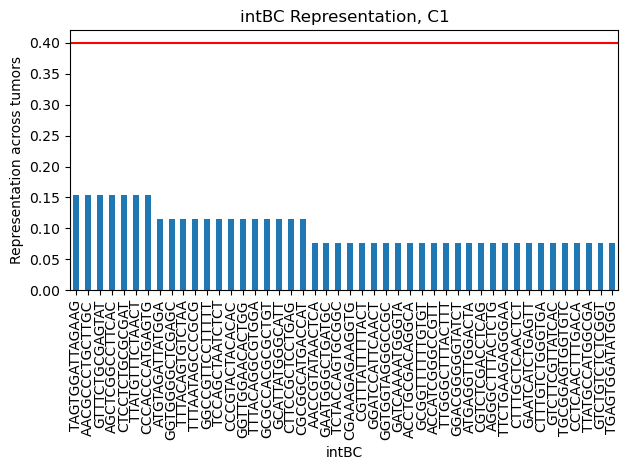

In [22]:
clone = 'C1'
consensus_filter_bound = 0.4

props = es_rep_dfs[clone].copy()
props[props >= 0.1] = 1
props[props < 0.1] = 0

props2 = props.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
props2.columns = ['intBC', 'prop']
props2 = props2.loc[props2['prop'] > 0]

props2.index = props2.intBC
props2 = props2.sort_values(by = 'prop', ascending=False)

ibcs = props2[props2['prop'] > consensus_filter_bound].index  

plt.close()
props2[props2['prop'] > 0.05]['prop'].plot(kind = 'bar')
plt.axhline(y = consensus_filter_bound, color='red')
plt.ylabel('Representation across tumors')
plt.title('intBC Representation, ' + clone)
plt.tight_layout()
plt.show()

## Figures with filtered allele table

The plots below are made with a completely filtered allele table - after filtering out "normal" cells with few cut intBCs and subsetting intBCs to only those identified as consensus intBCs.

In [23]:
allele_table_final = pd.read_csv(f"{data_directory}/allele/AP.alleleTable.unfiltered.txt2", sep='\t', converters={"Cell_Clone": str})

In [24]:
at_piv = pd.pivot_table(allele_table_final, index="cellBC", columns="intBC", values="UMI", aggfunc="sum")
at_piv.fillna(value = 0, inplace=True)
at_piv[at_piv > 0] = 1

es_rep_dfs = {}

for esc in tqdm_notebook(es_clones):
    
    if type(esc) != str:
        continue
    
    tumors = allele_table_final.loc[allele_table_final['Cell_Clone'] == esc, 'Tumor'].unique()
    tumor_dict = {}
    
    for tumor in tumors:
    
        cells = allele_table_final.loc[allele_table_final['Tumor'] == tumor, 'cellBC'].unique()
        tumor_piv = at_piv.loc[cells]
        
        if tumor_piv.shape[0] == 0:
            continue
            
        tumor_piv = tumor_piv.loc[:, tumor_piv.sum(axis=0) > 0]
            
        props = tumor_piv.apply(lambda x: np.sum(x>0) / len(x)).to_frame().reset_index()
        props.columns = ['intBC', 'prop']

        props = props.sort_values(by = 'prop', ascending=False)
        props = props[(props['intBC'] != 'NC')]

        props.index = props.intBC

        tumor_dict[tumor] = props['prop'].to_dict()
    
    if len(tumor_dict) > 0:
        tumor_df = pd.DataFrame.from_dict(tumor_dict, orient='index')
        tumor_df.fillna(value = 0, inplace=True)
        es_rep_dfs[esc] = tumor_df

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

### Figure 1D: intBC expression

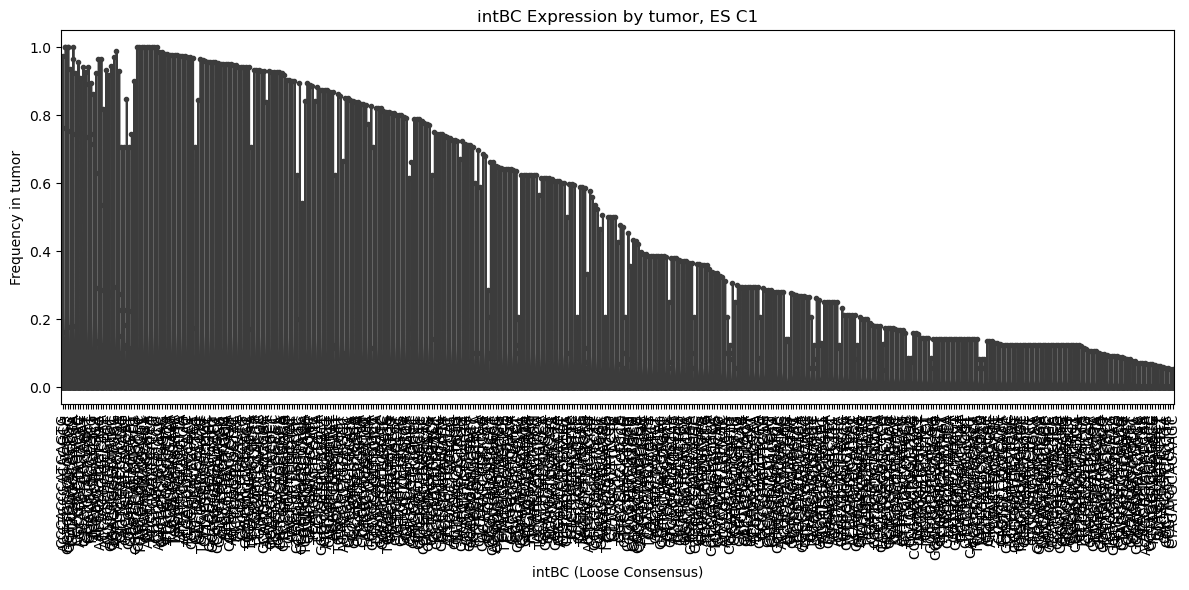

In [25]:
clone = 'C1'
ibcs = allele_table_final.loc[allele_table_final['Cell_Clone'] == clone, 'intBC'].unique()
ibcs = es_rep_dfs[clone][ibcs].mean(axis=0).sort_values(ascending=False).index.values

melted = pd.melt(es_rep_dfs[clone][ibcs])
h = plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="variable", y="value",
            data=melted, palette="muted", inner='point', cut=0, scale='count')
plt.xticks(rotation = 90)
plt.xlabel('intBC (Loose Consensus)')
plt.ylabel('Frequency in tumor')
plt.title('intBC Expression by tumor, ES ' +  clone)

plt.tight_layout()

### Figure S1G: intBC / cellBC pivot

In [26]:
clone_sizes = allele_table_final.groupby('Cell_Clone').agg({'cellBC': 'nunique'}).sort_values(by = 'cellBC')

# order tumors by ES clone ident
cell_ordering = []
es_annotation = []
es_to_intbcs = {}
for es in tqdm_notebook(clone_sizes.index):
    all_tumors = allele_table_final.loc[allele_table_final['Cell_Clone'] == es, 'Tumor'].unique()
    
    intBCs = allele_table_final.loc[allele_table_final['Cell_Clone'] == es, 'intBC'].value_counts().sort_values(ascending=False).index
    es_to_intbcs[es] = intBCs
    
    tumors = []
    for tumor in all_tumors:
        if tumor in tumor_list['Tumor'].tolist():
            tumors.append(tumor)

    for tumor in tumors:
        cells = allele_table_final.loc[allele_table_final['Tumor'] == tumor, 'cellBC'].unique()
        cell_ordering += list(cells)
        es_annotation += [es]*len(cells)

at_piv = pd.pivot_table(allele_table_final, columns='intBC', index='cellBC', values='UMI')
at_piv[at_piv > 0] = 1

at_piv = at_piv.loc[cell_ordering]

/home/yanzeqin/miniconda3/envs/KP/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/2 [00:00<?, ?it/s]

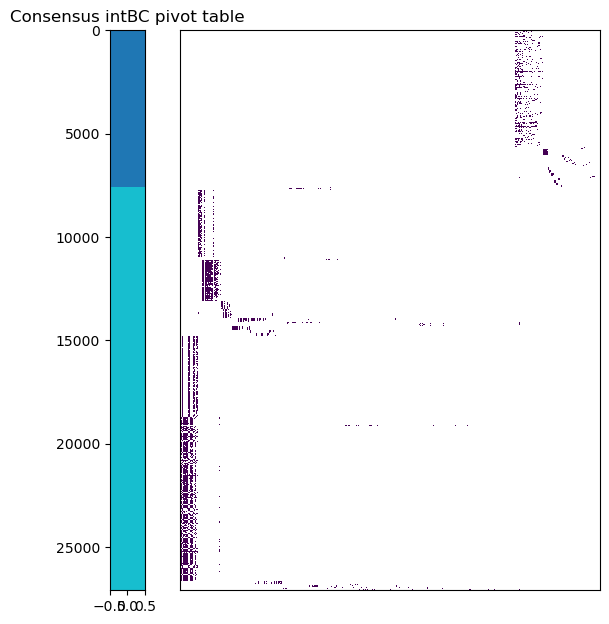

In [27]:
all_consensus_ibcs = []
for es_clone in clone_sizes.index[::-1]:
    if es_clone in es_annotation:
        all_consensus_ibcs += list(es_to_intbcs[es_clone])

colors = list(plt.get_cmap('tab10').colors)
module_colors = {j: colors[(i-1) % len(colors)] for i, j in zip(range(len(np.unique(es_annotation))), np.unique(es_annotation))}

row_colors = pd.Series([module_colors[i] for i in es_annotation], index = at_piv.index)
cbar_mat = np.zeros((len(row_colors), 1, 3))
for r in range(len(row_colors)):
    cbar_mat[r, 0, :] = row_colors.iloc[r][0], row_colors.iloc[r][1], row_colors.iloc[r][2]

h2 = plt.figure(2,figsize=(7,7))
axmat2 = h2.add_axes([0.3,0.1,0.6,0.8])
im2 = axmat2.matshow(at_piv[all_consensus_ibcs], aspect='auto', origin='upper')
axmat2.set_yticks([])
axmat2.set_xticks([])

cbar = h2.add_axes([0.2, 0.1, 0.05, 0.8])
im3 = cbar.imshow(cbar_mat, aspect='auto', origin='upper', interpolation="none")

plt.title('Consensus intBC pivot table')
plt.show()

### Figure S1H: Tumor Quality-Control

In [28]:
tumor_stats = {}
tum_errors = []
numerr = 0

for tumor, tum_at in allele_table_final.groupby('Tumor'):
    print(tumor)
    clone = meta.loc[meta['Tumor'] == tumor, 'Cell_Clone'].iloc[0]

    tumor_at = allele_table_final[allele_table_final['Tumor'] == tumor].copy()
    tumor_at['lineageGrp'] = tumor_at['Tumor'].copy()
    lg = lg_util.collectAlleles(tumor_at, thresh=0.2)[0]

    # drop normal cells from lg
    n_cs = len(lg['intBC'].unique())*3
    #filt = lg.apply(lambda x: not meta.loc[x.cellBC, 'is_normal'], axis=1)
    #lg = lg.loc[filt]
    
    try:
        cm, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, allele_rep_thresh = 0.98)
    except:
        cm, priors, state2indel = util.alleletable_to_character_matrix(lg, write=False, allele_rep_thresh = 1.0)
    
    number_dropped_intbcs = (n_cs - cm.shape[1]) 
    pu = cm.apply(lambda x: percent_uncut(x.values), axis=1)

    cmf = cm[pu < 0.9]

    
    print(cmf.shape[0])
    if cmf.shape[0] == 0:
        continue

    puniq = cmf.drop_duplicates().shape[0] / cmf.shape[0]
    
    number_dropped_intbcs
    tumor_stats[tumor] = (puniq, compute_perc_indels(cmf), number_dropped_intbcs, 1.0 - (number_dropped_intbcs / n_cs), cmf.shape[0])

CTR_MGH_0


100%|██████████| 1/1 [00:00<00:00, 120.98it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCAAGATAGGCCA_r1', 'GTCAAGATAGGCCA_r2', 'GTCAAGATAGGCCA_r3', 'GCTTGTTCATGTGT_r1', 'GCTTGTTCATGTGT_r2', 'GCTTGTTCATGTGT_r3', 'GGATGGTCTAGTCA_r1', 'GGATGGTCTAGTCA_r2', 'GGATGGTCTAGTCA_r3', 'CCCCGCTTCATTGC_r1', 'CCCCGCTTCATTGC_r2', 'CCCCGCTTCATTGC_r3', 'GATAGTATGGTGTG_r2', 'GATAGTATGGTGTG_r3', 'TATCTTAGCTACAT_r1', 'TATCTTAGCTACAT_r2', 'TATCTTAGCTACAT_r3', 'ATGCGCCGTTCTAC_r1', 'ATGCGCCGTTCTAC_r2', 'ATGCGCCGTTCTAC_r3', 'CGCCGGGGTGGGGT_r1', 'CGCCGGGGTGGGGT_r2', 'CGCCGGGGTGGGGT_r3', 'ATGCACAGTGCTCA_r1', 'ATGCACAGTGCTCA_r2', 'ATGCACAGTGCTCA_r3', 'CATTGTTCTAAATA_r1', 'CATTGTTCTAAATA_r2', 'CATTGTTCTAAATA_r3', 'AGCTGATTCTTCAC_r1', 'AGCTGATTCTTCAC_r2', 'AGCTGATTCTTCAC_r3', 'TCAACTCCAGAGTT_r1', 'TCAACTCCAGAGTT_r2', 'TCAACTCCAGAGTT_r3', 'TCAAGAGTGCCCTT_r1', 'TCAAGAGTGCCCTT_r2', 'TCAAGAGTGCCCTT_r3', 'AATTTAAATGCGGC_r1', 'AATTTAAATGCGGC_r2', 'AATTTAAATGCGGC_r3', 'GTGAGACGGAAGGA_r1', 'GTGAGACGGAAGGA_r2', 'GTGAGACGGAAGGA_r3',

Processing characters: 100%|██████████| 22/22 [00:00<00:00, 17341.61it/s]


97
CTR_MGH_1


100%|██████████| 1/1 [00:00<00:00, 80.10it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCTGAGTCCTTAG_r1', 'GTCTGAGTCCTTAG_r2', 'TGAGTGGATATGGG_r1', 'TGAGTGGATATGGG_r2', 'TGAGTGGATATGGG_r3', 'TTATGCCATGGCGA_r2', 'TTATGCCATGGCGA_r3']


Processing characters: 100%|██████████| 14/14 [00:00<00:00, 575.23it/s]


3228
CTR_MGH_10


100%|██████████| 1/1 [00:00<00:00, 217.93it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGTGTCGCATCTG_r2', 'ATGTGTCGCATCTG_r3', 'CACGCTCTCTGGAC_r2', 'CACGCTCTCTGGAC_r3', 'CCGTGTGGCGAGCA_r1']


Processing characters: 100%|██████████| 7/7 [00:00<00:00, 31843.96it/s]


64
CTR_MGH_11


100%|██████████| 1/1 [00:00<00:00, 214.38it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TACATCCCTGCAAA_r2', 'TACATCCCTGCAAA_r3', 'CGCTCTCCTTCATT_r1', 'AACTAGAATCATCT_r2']


Processing characters: 100%|██████████| 11/11 [00:00<00:00, 38161.57it/s]

40
CTR_MGH_12



100%|██████████| 1/1 [00:00<00:00, 197.81it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGGCTTTGAGGTTT_r1', 'ATTATTCTAAAGGG_r3', 'AGAGTTTACTTTGT_r1', 'CGGCGCAGGAGTTG_r1', 'CGGCGCAGGAGTTG_r2', 'CGGCGCAGGAGTTG_r3']


Processing characters: 100%|██████████| 12/12 [00:00<00:00, 48118.21it/s]


38
CTR_MGH_2


100%|██████████| 1/1 [00:00<00:00, 39.41it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGTTGTGGCTCTGA_r3', 'TCATGAAGTCCATC_r1', 'TAGTGCGCCTTCTT_r1', 'TAGTGCGCCTTCTT_r2', 'TAGTGCGCCTTCTT_r3', 'TGCCGCCCTCCTCC_r1', 'TGCCGCCCTCCTCC_r2', 'TGCCGCCCTCCTCC_r3', 'TCATGATGCACTTT_r1', 'TCATGATGCACTTT_r2', 'TCATGATGCACTTT_r3', 'TTATGTTTCGACGA_r1', 'TTATGTTTCGACGA_r2', 'GAGCGCTTTGTTAT_r1', 'GGAAGTGTCACGCT_r1', 'GGAAGTGTCACGCT_r3', 'GGCAGCTCTGGATC_r2', 'TTCCGATTCCTCTT_r2', 'TTCCGATTCCTCTT_r3', 'CTTAGTCACGCGGT_r1', 'CTTAGTCACGCGGT_r2', 'CTTAGTCACGCGGT_r3', 'ACTACTACCTAGTT_r1', 'CTCTGAGCGGGACA_r2', 'CTCTGAGCGGGACA_r3', 'GAACGTTCCGGGGT_r1', 'GAACGTTCCGGGGT_r2', 'GAACGTTCCGGGGT_r3', 'CATATTTCCCACTT_r1', 'AACTTATTCGCACC_r2', 'AACTTATTCGCACC_r3']


Processing characters: 100%|██████████| 29/29 [00:00<00:00, 947.19it/s]


1934
CTR_MGH_3


100%|██████████| 1/1 [00:00<00:00, 172.39it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AAGGTTACTCAACT_r2', 'AAGGTTACTCAACT_r3', 'GCCTAGTACTCCTC_r2', 'GCCTAGTACTCCTC_r3', 'TGGGAATCAGATTC_r1', 'TGGGAATCAGATTC_r2', 'TGGGAATCAGATTC_r3']


Processing characters: 100%|██████████| 11/11 [00:00<00:00, 4347.25it/s]


423
CTR_MGH_4


100%|██████████| 1/1 [00:00<00:00, 159.78it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AACGCTCTTGTTTA_r1', 'AACGCTCTTGTTTA_r2', 'AACGCTCTTGTTTA_r3', 'GCAATGGCAGGGAC_r2', 'GCAATGGCAGGGAC_r3', 'TTTCAGACCCTCCG_r1', 'TTTCAGACCCTCCG_r2', 'GTTTGTGAGTAGAG_r1', 'GTTTGTGAGTAGAG_r2', 'GTTTGTGAGTAGAG_r3', 'GTGCGTTTTCATCG_r3', 'GGCCCCGGACTGTA_r2', 'GCTTATCACCGAGA_r1', 'GCTTATCACCGAGA_r2']


Processing characters: 100%|██████████| 13/13 [00:00<00:00, 5864.27it/s]


406
CTR_MGH_5


100%|██████████| 1/1 [00:00<00:00, 102.64it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTCCGTCATTGTG_r2', 'TTTCCGTCATTGTG_r3', 'TGACCTCTGGTCTC_r1', 'TGACCTCTGGTCTC_r3', 'TTCTGTGACATGAA_r1', 'TTCTGTGACATGAA_r3', 'TGAGCCCATTAGCA_r1', 'TGAGCCCATTAGCA_r3', 'TCTTGTTCTTGCTC_r1', 'TCTTGTTCTTGCTC_r3', 'TGCCTTGGTTACTT_r2', 'TGCCTTGGTTACTT_r3', 'GTTCGGCGTGCCCT_r1', 'GTTCGGCGTGCCCT_r3', 'TCGGTGGGCGAATA_r3', 'TCTCGATGTAATAT_r1', 'TTTCGCGGAGTTCA_r1', 'TAATCAGTTTGTTT_r1', 'TAATCAGTTTGTTT_r2', 'GTTCAAAGTTCTGG_r3', 'GTCCGCTTCGTTTC_r1', 'GCAGTGATACACTG_r1', 'GCGTGGTGCGTTAC_r1', 'GCGTGGTGCGTTAC_r3', 'GCCCGTGTGTGTCA_r3', 'GATCGATTGGGCCC_r1', 'GCCCGTCCTTGTTC_r1', 'GCCCGTCCTTGTTC_r3', 'GAGTGTAGGGGATG_r1', 'GAGTGTAGGGGATG_r3', 'GACCGTATGCGCGG_r2', 'GACCGTATGCGCGG_r3', 'GACACTTTTCGGCA_r1', 'CGAAAATCGGCCAG_r1', 'CGAAAATCGGCCAG_r2', 'CGAAAATCGGCCAG_r3', 'CGCGGACCGGGCTC_r1', 'CGCGGACCGGGCTC_r3', 'CCTCCATTATGACC_r1', 'CCTAGTCCTTAGTA_r1', 'CCTAGTCCTTAGTA_r3', 'CCGTGTATATTCAA_r1', 'CCGTGTATATTCAA_r2', 'CCGTGTATATTCAA_r3']

Processing characters: 100%|██████████| 34/34 [00:00<00:00, 17482.69it/s]


104
CTR_MGH_6


100%|██████████| 1/1 [00:00<00:00, 87.33it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCCCGCTCGTTGAT_r1', 'GCCCGCTCGTTGAT_r2', 'GCCCGCTCGTTGAT_r3', 'CTTTGTATAGTTAG_r1', 'CTTTGTATAGTTAG_r2', 'CTTTGTATAGTTAG_r3', 'CTCGGGTTTGTCAG_r1', 'CTCGGGTTTGTCAG_r2', 'CTCGGGTTTGTCAG_r3', 'GTTCGTAAGGATGA_r1', 'GTTCGTAAGGATGA_r2', 'GTTCGTAAGGATGA_r3', 'ATAGGTTAAAATCC_r1', 'ATAGGTTAAAATCC_r2', 'ATAGGTTAAAATCC_r3', 'CAGAGTAGAACGTT_r1', 'CAGAGTAGAACGTT_r2', 'CAGAGTAGAACGTT_r3', 'ATCTTTGCCTGATG_r1', 'ATCTTTGCCTGATG_r2', 'ATCTTTGCCTGATG_r3', 'TTTAGGTACGATAC_r1', 'TTTAGGTACGATAC_r2', 'TTTAGGTACGATAC_r3', 'GTGCCCTGTCCCTA_r1', 'GTGCCCTGTCCCTA_r2', 'GTGCCCTGTCCCTA_r3', 'GCACGGGGTGATGC_r1', 'GCACGGGGTGATGC_r2', 'GCACGGGGTGATGC_r3', 'GTTGTTGATGCTGG_r1', 'GTTGTTGATGCTGG_r2', 'GTTGTTGATGCTGG_r3', 'ATCAGTACCTTTTT_r1', 'ATCAGTACCTTTTT_r2', 'ATCAGTACCTTTTT_r3', 'ATCGTCCGGGATGT_r1', 'ATCGTCCGGGATGT_r2', 'ATCGTCCGGGATGT_r3', 'GTGTGACAGCTCTA_r1', 'GTGTGACAGCTCTA_r2', 'GTGTGACAGCTCTA_r3', 'TCTCGACAGCCCTT_r1', 'TCTCGACAGCCCTT_r2',

Processing characters: 100%|██████████| 3/3 [00:00<00:00, 10791.52it/s]

70
CTR_MGH_7



100%|██████████| 1/1 [00:00<00:00, 151.74it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGACGAGTAGGCCC_r1', 'TGACGAGTAGGCCC_r2', 'TTGCGTGACCACGG_r1', 'TTGCGTGACCACGG_r2', 'TTTCGTATTCGATA_r1', 'TTTCGTATTCGATA_r2', 'GAAATTGTTCGGCC_r1', 'GAAATTGTTCGGCC_r2', 'CTTATAGTCGCGAC_r1', 'CTTATAGTCGCGAC_r2', 'GGCTAGTTAAGGAC_r1', 'GGCTAGTTAAGGAC_r2', 'CGCCATGCTTGAAA_r1', 'CGCCATGCTTGAAA_r2', 'CGCCATGCTTGAAA_r3', 'ATTTCGGTAGGTTC_r1', 'ATTTCGGTAGGTTC_r2', 'ATTTCGGTAGGTTC_r3', 'GCGCGGTTTCAACT_r1', 'GCGCGGTTTCAACT_r2', 'TGGGGGAAGATAGG_r1', 'TGGGGGAAGATAGG_r2', 'GCAAGTTATTACTC_r1', 'GCAAGTTATTACTC_r2', 'GCAAGTTATTACTC_r3', 'GGCACTAAAAAGCA_r1', 'GGCACTAAAAAGCA_r2', 'TGACGCGGGGAAAT_r1', 'TGACGCGGGGAAAT_r2', 'TGACGCGGGGAAAT_r3', 'CCTTGGTCAGTCAC_r1', 'CCTTGGTCAGTCAC_r2']


Processing characters: 100%|██████████| 10/10 [00:00<00:00, 10106.76it/s]


187
CTR_MGH_8


100%|██████████| 1/1 [00:00<00:00, 163.06it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACAAAGTCGACTCT_r1', 'ACAAAGTCGACTCT_r2', 'ACAAAGTCGACTCT_r3', 'TTTGTCGTCATCAC_r1', 'TTTGTCGTCATCAC_r2', 'TTTGTCGTCATCAC_r3', 'TTTCGAGGAGTGCT_r1', 'TTTCGAGGAGTGCT_r2', 'TTTCGAGGAGTGCT_r3', 'GCGTCAGGAGTCGA_r1', 'GCGTCAGGAGTCGA_r2', 'GCGTCAGGAGTCGA_r3', 'GTTTGCGTAGCTGC_r1', 'GTTTGCGTAGCTGC_r2', 'GTTTGCGTAGCTGC_r3', 'GTGAGTACTTATCC_r1', 'GTGAGTACTTATCC_r2', 'GTGAGTACTTATCC_r3', 'GGTCCTGCACTAGG_r2', 'GGTCCTGCACTAGG_r3']


Processing characters: 100%|██████████| 16/16 [00:00<00:00, 15650.39it/s]


118
CTR_MGH_9


100%|██████████| 1/1 [00:00<00:00, 184.50it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATTGGCTTGGCCAT_r1', 'ATTGGCTTGGCCAT_r2', 'TCCTATTCCGGTTA_r1', 'TCCTATTCCGGTTA_r2', 'TCCTATTCCGGTTA_r3', 'GCTGGGAAACAATG_r1', 'GCTGGGAAACAATG_r2', 'GCTGGGAAACAATG_r3', 'CGTGATTGACCGGG_r1', 'CGTGATTGACCGGG_r2', 'CGTGATTGACCGGG_r3', 'CCGCGCGGACGGCT_r1', 'TGGGCGGATGGCGT_r1', 'TGGGCGGATGGCGT_r2', 'TGGGCGGATGGCGT_r3', 'TTATGCGGCGTTCA_r2', 'TTATGCGGCGTTCA_r3']


Processing characters: 100%|██████████| 7/7 [00:00<00:00, 11531.86it/s]


139
CTR_RT_0


100%|██████████| 1/1 [00:00<00:00, 287.87it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 31378.83it/s]

22
CTR_RT_1



100%|██████████| 1/1 [00:00<00:00, 41.88it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCGTGTCAGGTCCG_r1', 'CCGTGTCAGGTCCG_r2', 'CCGTGTCAGGTCCG_r3', 'GTCTAATGTTTCTT_r1', 'GTCTAATGTTTCTT_r2', 'GTCTAATGTTTCTT_r3', 'TCATCCCTCTTGAA_r1', 'TCATCCCTCTTGAA_r2', 'TCATCCCTCTTGAA_r3', 'TCCGGTGGCTCTTC_r1', 'TCCGGTGGCTCTTC_r2', 'TCCGGTGGCTCTTC_r3', 'TTCCGAGTTCGCTC_r1', 'TTCCGAGTTCGCTC_r2', 'TTCCGAGTTCGCTC_r3']


Processing characters: 100%|██████████| 12/12 [00:00<00:00, 752.26it/s]


3368
GEM_RT_0


100%|██████████| 1/1 [00:00<00:00, 192.24it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATTCGTAGGGCCTC_r1', 'ATTCGTAGGGCCTC_r2', 'ATTCGTAGGGCCTC_r3', 'GTCTGTCCCGTTTT_r1', 'GTCTGTCCCGTTTT_r2', 'GTCTGTCCCGTTTT_r3', 'TGCGGTTGGTCGGG_r1', 'TGCGGTTGGTCGGG_r2', 'TGCGGTTGGTCGGG_r3', 'GTAGAGAGGGGGTG_r1', 'GTAGAGAGGGGGTG_r2', 'GTAGAGAGGGGGTG_r3', 'CAACGTTGAGCGTT_r1', 'CAACGTTGAGCGTT_r2', 'CAACGTTGAGCGTT_r3', 'TAAGCAGTTGCGCT_r1', 'TAAGCAGTTGCGCT_r2', 'TAAGCAGTTGCGCT_r3', 'GTACGCTCCCACCT_r1', 'GTACGCTCCCACCT_r2', 'GTACGCTCCCACCT_r3', 'GGTCGACGAGTTAG_r1', 'GGTCGACGAGTTAG_r2', 'GGTCGACGAGTTAG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 24/24 [00:00<00:00, 47304.18it/s]


0
GEM_RT_1


100%|██████████| 1/1 [00:00<00:00, 189.41it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GCACAAGGAGAATC_r1', 'GCACAAGGAGAATC_r2', 'GCACAAGGAGAATC_r3', 'ACTCGGTCCGGCTT_r1', 'ACTCGGTCCGGCTT_r2', 'ACTCGGTCCGGCTT_r3', 'GCGAGTTGTTCCGC_r1', 'GCGAGTTGTTCCGC_r2', 'GCGAGTTGTTCCGC_r3', 'GTCTACAGTGGTCT_r1', 'GTCTACAGTGGTCT_r2', 'GTCTACAGTGGTCT_r3', 'TGGTGTTAACTATC_r1', 'TGGTGTTAACTATC_r2', 'TGGTGTTAACTATC_r3', 'GGTGGGTGTACTCA_r1', 'GGTGGGTGTACTCA_r2', 'GGTGGGTGTACTCA_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 18/18 [00:00<00:00, 13706.88it/s]


0
GEM_RT_10


100%|██████████| 1/1 [00:00<00:00, 246.48it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GGGCAGTGGATAGG_r1', 'GGGCAGTGGATAGG_r2', 'GGGCAGTGGATAGG_r3', 'TTTTGTTTTCTTTC_r1', 'TTTTGTTTTCTTTC_r2', 'TTTTGTTTTCTTTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 37282.70it/s]


0
GEM_RT_11


100%|██████████| 1/1 [00:00<00:00, 230.14it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTCACAATTGGAGT_r1', 'CTCACAATTGGAGT_r2', 'CTCACAATTGGAGT_r3', 'CACTATCGTACCTT_r1', 'CACTATCGTACCTT_r2', 'CACTATCGTACCTT_r3', 'CATCATTGGTGCTC_r1', 'CATCATTGGTGCTC_r2', 'CATCATTGGTGCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 42799.02it/s]


0
GEM_RT_12


100%|██████████| 1/1 [00:00<00:00, 261.80it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CATACTGAAGATGG_r1', 'CATACTGAAGATGG_r2', 'CATACTGAAGATGG_r3', 'GTCGGCGCATGCTC_r1', 'GTCGGCGCATGCTC_r2', 'GTCGGCGCATGCTC_r3', 'AATAGATACCGTTG_r1', 'AATAGATACCGTTG_r2', 'AATAGATACCGTTG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 43640.16it/s]


0
GEM_RT_13


100%|██████████| 1/1 [00:00<00:00, 246.23it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGAACATGTCATGG_r1', 'CGAACATGTCATGG_r2', 'TCCGGTTTCGCATC_r2', 'TCCGGTTTCGCATC_r3']


Processing characters: 100%|██████████| 5/5 [00:00<00:00, 32665.92it/s]

19


GEM_RT_14


100%|██████████| 1/1 [00:00<00:00, 226.05it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 30102.66it/s]


66
GEM_RT_15


100%|██████████| 1/1 [00:00<00:00, 225.15it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATCTGGCTCGACTT_r1', 'ATCTGGCTCGACTT_r2']


Processing characters: 100%|██████████| 4/4 [00:00<00:00, 30615.36it/s]


36
GEM_RT_16


100%|██████████| 1/1 [00:00<00:00, 239.09it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGCGGCATACATC_r1', 'ACGCGGCATACATC_r2', 'ACGCGGCATACATC_r3', 'CCGAGCCGATTGAC_r1', 'CCGAGCCGATTGAC_r2', 'CCGAGCCGATTGAC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 43166.08it/s]


0
GEM_RT_17


100%|██████████| 1/1 [00:00<00:00, 220.50it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAATGTTTCATCAT_r1', 'CAATGTTTCATCAT_r2', 'CAATGTTTCATCAT_r3', 'AGCCGTTCCCCCGT_r1', 'AGCCGTTCCCCCGT_r2', 'AGCCGTTCCCCCGT_r3', 'TCCTCAAGACCCTC_r1', 'TCCTCAAGACCCTC_r2', 'TCCTCAAGACCCTC_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 62086.74it/s]


0
GEM_RT_18


100%|██████████| 1/1 [00:00<00:00, 274.14it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATGGGTGTCCCTTA_r2']


Processing characters: 100%|██████████| 2/2 [00:00<00:00, 23629.88it/s]


11
GEM_RT_19


100%|██████████| 1/1 [00:00<00:00, 240.47it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTTCCTGGCTCAAT_r1', 'GTTCCTGGCTCAAT_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]

4
GEM_RT_2



100%|██████████| 1/1 [00:00<00:00, 228.30it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CCGGGCTTAATCTT_r1', 'CCGGGCTTAATCTT_r2', 'CCGGGCTTAATCTT_r3', 'CCAAGCTCTGCCAA_r1', 'CCAAGCTCTGCCAA_r2', 'CCAAGCTCTGCCAA_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 21094.57it/s]


0
GEM_RT_20


100%|██████████| 1/1 [00:00<00:00, 253.42it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCTGTCGCGTTTC_r1', 'GTCTGTCGCGTTTC_r2', 'GTCTGTCGCGTTTC_r3']


Processing characters: 100%|██████████| 3/3 [00:00<00:00, 27838.30it/s]

26
GEM_RT_3



100%|██████████| 1/1 [00:00<00:00, 248.07it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CGTTGCTTAGACGG_r1', 'CGTTGCTTAGACGG_r2', 'CGTTGCTTAGACGG_r3', 'TAGGACAAGCATAG_r1', 'TAGGACAAGCATAG_r2', 'TAGGACAAGCATAG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 21583.04it/s]


0
GEM_RT_4


100%|██████████| 1/1 [00:00<00:00, 209.31it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCTGTTTTATGATT_r1', 'TCTGTTTTATGATT_r2', 'TCTGTTTTATGATT_r3', 'GTCTCCGGACACTT_r1', 'GTCTCCGGACACTT_r2', 'GTCTCCGGACACTT_r3', 'TGACAATTTGCGCA_r1', 'TGACAATTTGCGCA_r2', 'TGACAATTTGCGCA_r3', 'TGGGCTTTGCTTTA_r1', 'TGGGCTTTGCTTTA_r2', 'TGGGCTTTGCTTTA_r3', 'AATTCACCTTAGTT_r1', 'AATTCACCTTAGTT_r2', 'AATTCACCTTAGTT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 15/15 [00:00<00:00, 25461.17it/s]


0
GEM_RT_5


100%|██████████| 1/1 [00:00<00:00, 190.30it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ATCGGGCTCGGACC_r1', 'ATCGGGCTCGGACC_r2', 'ATCGGGCTCGGACC_r3', 'ATGCGTTAACCGTC_r1', 'ATGCGTTAACCGTC_r2', 'ATGCGTTAACCGTC_r3', 'GCTCGTCACGTTCT_r1']


Processing characters: 100%|██████████| 5/5 [00:00<00:00, 24789.03it/s]


8
GEM_RT_6


100%|██████████| 1/1 [00:00<00:00, 245.74it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CAGAGGCTTGGTGC_r1', 'CAGAGGCTTGGTGC_r2', 'CAGAGGCTTGGTGC_r3', 'GGGACAGCTGGGGG_r1', 'GGGACAGCTGGGGG_r3', 'TTAAAGGGTGGTCT_r1', 'TTAAAGGGTGGTCT_r2', 'TTAAAGGGTGGTCT_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 8065.97it/s]


3
GEM_RT_7


100%|██████████| 1/1 [00:00<00:00, 247.25it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 16799.62it/s]

117


GEM_RT_8


100%|██████████| 1/1 [00:00<00:00, 217.36it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTCTAGAATGTAA_r1', 'TTTCTAGAATGTAA_r2', 'TTTCTAGAATGTAA_r3', 'GAGTATTTTCTGTC_r1', 'GAGTATTTTCTGTC_r2', 'GAGTATTTTCTGTC_r3', 'TCCTACCGAGTGGT_r1', 'TCCTACCGAGTGGT_r2', 'TCCTACCGAGTGGT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 29468.18it/s]


0
GEM_RT_9


100%|██████████| 1/1 [00:00<00:00, 255.75it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGAGCAGCTAGCG_r1', 'GTGAGCAGCTAGCG_r2', 'GTGAGCAGCTAGCG_r3', 'CGCTTTCCATCTAT_r1', 'CGCTTTCCATCTAT_r2', 'CGCTTTCCATCTAT_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 6/6 [00:00<00:00, 30727.50it/s]


0
MI_MGH_0


100%|██████████| 1/1 [00:00<00:00, 111.95it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTCAGTGGATCCTC_r1', 'TTTACCGGGGGGCG_r1', 'TTTACCGGGGGGCG_r2', 'CCCCAGTCTAGTCT_r1', 'CCCCAGTCTAGTCT_r2', 'CCCCAGTCTAGTCT_r3', 'GATGACTGACTATG_r2', 'GATGACTGACTATG_r3', 'GGCCAAAAAAACTA_r1', 'GGCCAAAAAAACTA_r2', 'GGCCAAAAAAACTA_r3', 'GTATGCCAACTTCT_r1', 'GTATGCCAACTTCT_r2', 'GTATGCCAACTTCT_r3', 'TTTATCCAAGGCGG_r1', 'TTTATCCAAGGCGG_r2', 'TTTATCCAAGGCGG_r3', 'CATGGTGGTGTATA_r1', 'CAATGATCATTAGG_r3', 'AACCGGATATCATA_r2', 'GGCCAAAAAAAACT_r1', 'GGCCAAAAAAAACT_r2', 'GGCCAAAAAAAACT_r3']


Processing characters: 100%|██████████| 13/13 [00:00<00:00, 44186.35it/s]


35
MI_MGH_1


100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AACGCCCTGCTTGC_r1', 'AACGCCCTGCTTGC_r2', 'AACGCCCTGCTTGC_r3', 'ACCATCGGGCCGTT_r1', 'ACCATCGGGCCGTT_r2', 'ACCATCGGGCCGTT_r3', 'AGTGGCGTTCAAGA_r1', 'AGTGGCGTTCAAGA_r2', 'AGTGGCGTTCAAGA_r3', 'ATGTAGATTATGGA_r1', 'ATGTAGATTATGGA_r2', 'ATGTAGATTATGGA_r3', 'GAATGGGCTGATGC_r1', 'GAATGGGCTGATGC_r2', 'GAATGGGCTGATGC_r3', 'GCGGTTTTTTGTGT_r1', 'GCGGTTTTTTGTGT_r2', 'GCGGTTTTTTGTGT_r3', 'GGACGGGGGTATCT_r1', 'GGACGGGGGTATCT_r2', 'GGACGGGGGTATCT_r3', 'GTAAATACAGCGTG_r1', 'GTAAATACAGCGTG_r2', 'GTAAATACAGCGTG_r3', 'AGCTCGGCCTTCAC_r1', 'CCCACCCATGAGTG_r1', 'CCCGTACTACACAC_r2', 'CCCGTACTACACAC_r3', 'CTCCTCTGCGCGAT_r1', 'CTCCTCTGCGCGAT_r3', 'GGCCGTTCCTTTTT_r1', 'GGCCGTTCCTTTTT_r2', 'GGCCGTTCCTTTTT_r3', 'GGTTGGAACACTGG_r1', 'TCCAGCTAATCTCT_r1', 'TCCAGCTAATCTCT_r3', 'TTATGTTTCTAACT_r1', 'TTATGTTTCTAACT_r2', 'TTTAATAGCCCGCG_r1', 'TTTAATAGCCCGCG_r2', 'TTTAATAGCCCGCG_r3', 'TTTACAGGCGTGGA_r1', 'TTTACAGGCGTGGA_r3', 'GGTGGGGCTCGAGC_r1',

Processing characters: 100%|██████████| 12/12 [00:00<00:00, 286.19it/s]


3143
MI_MGH_2


100%|██████████| 1/1 [00:00<00:00, 136.17it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CTTATCAATGATGA_r1', 'CTTATCAATGATGA_r2', 'CTTGTATTGATTAT_r2', 'CTTGTATTGATTAT_r3', 'GCTTGCCTGCTTTG_r3', 'CAGTGCTTTGGTAT_r2', 'CAGTGCTTTGGTAT_r3', 'GCGTCAGCATCCAA_r2', 'GCGTCAGCATCCAA_r3', 'TTTTGCGACTCTAT_r1']


Processing characters: 100%|██████████| 29/29 [00:00<00:00, 14073.22it/s]


154
MI_MGH_3


100%|██████████| 1/1 [00:00<00:00, 171.58it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATCAAAATGGGTA_r1', 'GATCAAAATGGGTA_r2', 'GATCAAAATGGGTA_r3', 'ACCTGCGACAGGCA_r1', 'ACCTGCGACAGGCA_r2', 'ACCTGCGACAGGCA_r3', 'GGTGGTAGGGCCGC_r1', 'GGTGGTAGGGCCGC_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]


5
Met_MGH_0


100%|██████████| 1/1 [00:00<00:00, 143.44it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GTGCGGCTGGGCTC_r1', 'GTGCGGCTGGGCTC_r2', 'GTGCGGCTGGGCTC_r3', 'CGTCTCGACCTCAG_r2', 'CGTCTCGACCTCAG_r3', 'GGTTGCAGTTGGCC_r1', 'GGTTGCAGTTGGCC_r2', 'GGTTGCAGTTGGCC_r3', 'CTTTGCTCAACTCT_r2', 'ACGTCCGTGTATAT_r2', 'ACGTCCGTGTATAT_r3', 'AGGGCTTTACTCTG_r1', 'AGGGCTTTACTCTG_r2', 'CGCGGCATGACCAT_r2', 'CGCGGCATGACCAT_r3', 'GTTTCTGCGAGTAT_r2', 'GTTTCTGCGAGTAT_r3', 'TAGTGGATTAGAAG_r2', 'TAGTGGATTAGAAG_r3', 'TTCTGAAGAGGGAA_r2', 'TTCTGAAGAGGGAA_r3', 'TTGGGCTTTACTTT_r1', 'GCGCCACGCGCTGT_r1', 'GTCTTCGTTATCAC_r1', 'GTCTTCGTTATCAC_r3', 'CTTCCGCTCCTGAG_r1', 'CTTCCGCTCCTGAG_r2', 'GAATCATCTGAGTT_r1', 'CGACCTATTCATTC_r1', 'CGACCTATTCATTC_r2', 'GCATTATGGGCATT_r2', 'GCATTATGGGCATT_r3', 'ATGAGGTTGGACTA_r2', 'AACCGTATAACTCA_r1']


Processing characters: 100%|██████████| 32/32 [00:00<00:00, 116508.44it/s]

22
Met_MGH_1



100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['AGTGGCGTTCAAGA_r1', 'AGTGGCGTTCAAGA_r2', 'AGTGGCGTTCAAGA_r3', 'ATGTAGATTATGGA_r1', 'ATGTAGATTATGGA_r2', 'ATGTAGATTATGGA_r3', 'GAGACTATCGAGAT_r1', 'GAGACTATCGAGAT_r2', 'GAGACTATCGAGAT_r3', 'GCGGTTTTTTGTGT_r1', 'GCGGTTTTTTGTGT_r2', 'GCGGTTTTTTGTGT_r3', 'GGACGGGGGTATCT_r1', 'GGACGGGGGTATCT_r2', 'GGACGGGGGTATCT_r3', 'AACGCCCTGCTTGC_r1', 'AACGCCCTGCTTGC_r2', 'AACGCCCTGCTTGC_r3', 'ACCATCGGGCCGTT_r1', 'ACCATCGGGCCGTT_r2', 'ACCATCGGGCCGTT_r3', 'AGTTACAAGTAGCT_r1', 'AGTTACAAGTAGCT_r2', 'AGTTACAAGTAGCT_r3', 'CATGGCCTTTGAGT_r1', 'CATGGCCTTTGAGT_r2', 'CATGGCCTTTGAGT_r3', 'GAATGGGCTGATGC_r1', 'GAATGGGCTGATGC_r2', 'GAATGGGCTGATGC_r3', 'GTAAATACAGCGTG_r1', 'GTAAATACAGCGTG_r2', 'GTAAATACAGCGTG_r3', 'GCGGTTTTTTTGTG_r1', 'GCGGTTTTTTTGTG_r2', 'GCGGTTTTTTTGTG_r3']


Processing characters: 0it [00:00, ?it/s]


Dropping the following intBCs due to lack of diversity with threshold 1.0: []


Processing characters: 100%|██████████| 36/36 [00:00<00:00, 636.44it/s]


1
Met_MGH_2


100%|██████████| 1/1 [00:00<00:00, 116.02it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTTACAGGCGTGGA_r1', 'TTTACAGGCGTGGA_r3', 'CCCACCCATGAGTG_r1', 'CCCACCCATGAGTG_r3', 'CCCGTACTACACAC_r1', 'CCCGTACTACACAC_r2', 'CCCGTACTACACAC_r3', 'CTCCTCTGCGCGAT_r1', 'CTCCTCTGCGCGAT_r2', 'CTCCTCTGCGCGAT_r3', 'GGCCGTTCCTTTTT_r1', 'GGCCGTTCCTTTTT_r2', 'GGCCGTTCCTTTTT_r3', 'GGTTGGAACACTGG_r1', 'AGCTCGGCCTTCAC_r1', 'AGCTCGGCCTTCAC_r2', 'AGCTCGGCCTTCAC_r3', 'TCCAGCTAATCTCT_r1', 'TCCAGCTAATCTCT_r3', 'TTTAATAGCCCGCG_r1', 'TTTAATAGCCCGCG_r2', 'TTTAATAGCCCGCG_r3', 'TTTACAGTGTCTAA_r1', 'TTTACAGTGTCTAA_r2', 'TTTACAGTGTCTAA_r3', 'TTATGTTTCTAACT_r1', 'A_r1']


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 7501.74it/s]

345


Met_MGH_3


100%|██████████| 1/1 [00:00<00:00, 232.47it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['GATCAAAATGGGTA_r1', 'GATCAAAATGGGTA_r2', 'GATCAAAATGGGTA_r3', 'ACCTGCGACAGGCA_r1', 'ACCTGCGACAGGCA_r2', 'ACCTGCGACAGGCA_r3', 'GGTGGTAGGGCCGC_r1', 'GGTGGTAGGGCCGC_r3']


Processing characters: 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


2
NMI_MGH_0


100%|██████████| 1/1 [00:00<00:00, 116.07it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TGGACGAATTTTAG_r1', 'TTGTGCTGGCAGGG_r3', 'CCCTGTGCACGATA_r1', 'CCCTGTGCACGATA_r2', 'CCCTGTGCACGATA_r3', 'CTAAGTAAAGGAAA_r1', 'CTAAGTAAAGGAAA_r2', 'CTAAGTAAAGGAAA_r3', 'CTATGGGTATTCCG_r3', 'CTTCGCATTTCCTC_r1', 'CTTCGCATTTCCTC_r2', 'CTTCGCATTTCCTC_r3', 'GCACCATATGTTAG_r3', 'TAAACCAGTTTATT_r1', 'TAAACCAGTTTATT_r2', 'CCACGATCTCTGTG_r1', 'CCACGATCTCTGTG_r2', 'ATGTGTCCCTCTTT_r1', 'AGTTAACAGTGACA_r1', 'AGTTAACAGTGACA_r2', 'AGTTAACAGTGACA_r3', 'CCAAGATACCCTTC_r1', 'CCAAGATACCCTTC_r2', 'CCAAGATACCCTTC_r3', 'GAAGGCCAGTCTCT_r1', 'GAAGGCCAGTCTCT_r3', 'TAAGGCATTGTGCA_r1', 'TAAGGCATTGTGCA_r2', 'TAAGGCATTGTGCA_r3']


Processing characters: 100%|██████████| 16/16 [00:00<00:00, 158649.80it/s]


7
NMI_MGH_2


100%|██████████| 1/1 [00:00<00:00, 107.57it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TTCAGTTTTTTCTC_r1', 'TTCAGTTTTTTCTC_r2', 'TTCAGTTTTTTCTC_r3', 'TCCAGAAGTGCCAG_r1', 'TCCAGAAGTGCCAG_r2', 'TCCAGAAGTGCCAG_r3', 'GTTTGTGGCGAGTG_r2', 'GTTTGTGGCGAGTG_r3', 'GTGATTGGGGTTCA_r1', 'GTGATTGGGGTTCA_r3', 'GTCGACGGGAACGC_r1', 'GTCGACGGGAACGC_r2', 'GTCGACGGGAACGC_r3', 'CACCGGTAAGGCGA_r1', 'CACCGGTAAGGCGA_r2', 'CACCGGTAAGGCGA_r3', 'CTTGCTAGATACGG_r1', 'CTTGCTAGATACGG_r2', 'CTTGCTAGATACGG_r3', 'GACTTTCCTATTAT_r1', 'GGTTCTAAGGTGAC_r1', 'GGTTCTAAGGTGAC_r2', 'GGTTCTAAGGTGAC_r3', 'GGTTGTCTAAATGT_r1', 'GGTTGTCTAAATGT_r2', 'GGTTGTCTAAATGT_r3', 'ACACGATAAGCAAC_r1', 'ACACGATAAGCAAC_r2', 'ACACGATAAGCAAC_r3', 'AGCTCATAATGTCT_r1', 'AGCTCATAATGTCT_r3', 'GTTAGGTTCATCGC_r2', 'GTTAGGTTCATCGC_r3', 'TCCATTCGGGGGCA_r2', 'GGCTGGCCTTATAT_r2', 'GGCTGGCCTTATAT_r3', 'GGACGTTTCGCGCA_r3', 'TTCAGCCTATATGA_r1', 'AGTGACCTGCAGGG_r2', 'ATGGGCCTACAAGT_r3', 'CAAAAAATGGTGCG_r1', 'CAAAAAATGGTGCG_r2']


Processing characters: 100%|██████████| 30/30 [00:00<00:00, 31061.25it/s]


73
NMI_MGH_3


100%|██████████| 1/1 [00:00<00:00, 184.74it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['CATTATTACAGTAA_r1', 'CATTATTACAGTAA_r2', 'CATTATTACAGTAA_r3', 'AGTACTCAGGCGAA_r2', 'AGTACTCAGGCGAA_r3', 'ATCCAATCCGAATT_r2', 'ATCCAATCCGAATT_r3', 'GTATTTAAACCAGA_r2', 'CCTCGTTTGGTTCT_r1', 'CCTCGTTTGGTTCT_r2', 'CCTCGTTTGGTTCT_r3']


Processing characters: 100%|██████████| 7/7 [00:00<00:00, 23987.03it/s]


15
NMI_MGH_4


100%|██████████| 1/1 [00:00<00:00, 137.78it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TCCCGGTGTTAATA_r2', 'CTTAGAACTCCGGC_r2', 'CTTAGAACTCCGGC_r3']


Processing characters: 100%|██████████| 36/36 [00:00<00:00, 42847.60it/s]


40
NMI_MGH_5


100%|██████████| 1/1 [00:00<00:00, 161.19it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTGATTGGCGCC_r2', 'CGTGCGTGATTTGT_r1', 'CGTGCGTGATTTGT_r3', 'CTATTTGGCTTTGC_r1', 'CTATTTGGCTTTGC_r2', 'CTATTTGGCTTTGC_r3', 'GGCCTCTCGGCGGC_r1', 'GGCCTCTCGGCGGC_r2', 'GGCCTCTCGGCGGC_r3', 'GGCCTGGACTGCTT_r1', 'GGCCTGGACTGCTT_r3', 'CCATTCGTTAGCCT_r2']


Processing characters: 100%|██████████| 9/9 [00:00<00:00, 25385.83it/s]


69
NMI_MGH_6


100%|██████████| 1/1 [00:00<00:00, 126.16it/s]


Dropping the following intBCs due to lack of diversity with threshold 0.98: ['TAACGATTTGATCT_r1', 'TAACGATTTGATCT_r3', 'TTCCGTGTCCACAA_r1', 'TTCCGTGTCCACAA_r2', 'TTCCGTGTCCACAA_r3', 'GGATCCATTCAACT_r1', 'GGATCCATTCAACT_r2', 'GGATCCATTCAACT_r3', 'GTCTGCGGAGCCCC_r2', 'GTCTGCGGAGCCCC_r3', 'CAGTATTTCTCCTG_r1', 'CAGTATTTCTCCTG_r2', 'CAGTATTTCTCCTG_r3', 'ACGAAGGTAATAAC_r1', 'ACGAAGGTAATAAC_r2', 'ACGAAGGTAATAAC_r3', 'CGTCTCGTACTATT_r1', 'CTGTAGGATTTTCG_r1', 'CTGTAGGATTTTCG_r2', 'CTGTAGGATTTTCG_r3', 'GCATTATGGGCATT_r2', 'GCATTATGGGCATT_r3', 'TAGTGGATTAGAAG_r2', 'TAGTGGATTAGAAG_r3', 'GTTTCTGCGAGTAT_r2', 'GTTTCTGCGAGTAT_r3']


Processing characters: 100%|██████████| 7/7 [00:00<00:00, 41704.73it/s]

8

In [29]:
tumor_stats

{'CTR_MGH_0': (0.7938144329896907,
  0.3839907192575406,
  62,
  0.26190476190476186,
  97),
 'CTR_MGH_1': (0.6000619578686494,
  0.7035570111965876,
  7,
  0.6666666666666667,
  3228),
 'CTR_MGH_10': (0.3125, 0.34682080924855496, 5, 0.5833333333333333, 64),
 'CTR_MGH_11': (0.75, 0.3076923076923077, 4, 0.7333333333333334, 40),
 'CTR_MGH_12': (0.9473684210526315,
  0.4639423076923077,
  6,
  0.6666666666666667,
  38),
 'CTR_MGH_2': (0.8634953464322648,
  0.38968952509913923,
  31,
  0.4833333333333333,
  1934),
 'CTR_MGH_3': (0.6879432624113475,
  0.5352480417754569,
  7,
  0.6111111111111112,
  423),
 'CTR_MGH_4': (0.8620689655172413,
  0.5815886699507389,
  14,
  0.4814814814814815,
  406),
 'CTR_MGH_5': (0.8557692307692307,
  0.18065433854907542,
  44,
  0.4358974358974359,
  104),
 'CTR_MGH_6': (0.37142857142857144, 0.6174863387978142, 45, 0.0625, 70),
 'CTR_MGH_7': (0.9679144385026738,
  0.44993412384716736,
  32,
  0.23809523809523814,
  187),
 'CTR_MGH_8': (0.7288135593220338,
  

In [30]:
tumor_clone_statistics = pd.DataFrame.from_dict(tumor_stats, orient='index',
                                                columns = ['PercentUnique', 'CutRate', 'NumSaturatedTargets', 'PercentUnsaturatedTargets', 'NumCells'])

In [31]:
tumor_clone_statistics

,PercentUnique,CutRate,NumSaturatedTargets,PercentUnsaturatedTargets,NumCells
CTR_MGH_0,0.793814,0.383991,62,0.261905,97
CTR_MGH_1,0.600062,0.703557,7,0.666667,3228
CTR_MGH_10,0.312500,0.346821,5,0.583333,64
CTR_MGH_11,0.750000,0.307692,4,0.733333,40
CTR_MGH_12,0.947368,0.463942,6,0.666667,38
CTR_MGH_2,0.863495,0.389690,31,0.483333,1934
CTR_MGH_3,0.687943,0.535248,7,0.611111,423
CTR_MGH_4,0.862069,0.581589,14,0.481481,406
CTR_MGH_5,0.855769,0.180654,44,0.435897,104
CTR_MGH_6,0.371429,0.617486,45,0.062500,70


In [32]:
tumor_clone_statistics.to_csv(f"{data_directory}/allele/tumor_statistics.tsv",sep='\t',index=True,header=True)

Text(0, 0.5, 'Percent Unique')

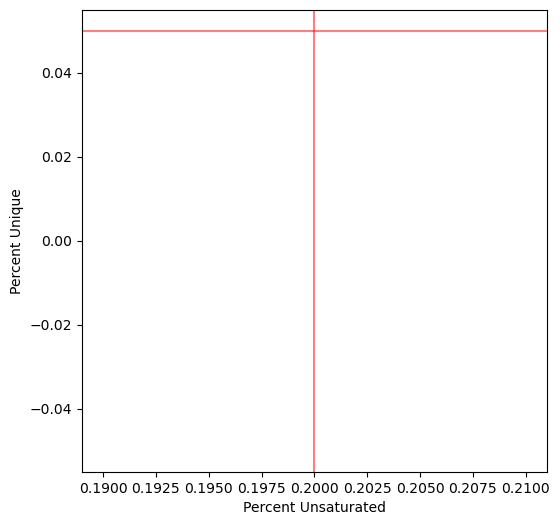

In [33]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

NT_primary_tumors = tumor_clone_statistics[tumor_clone_statistics.apply(lambda x: 'NT' in x.name and x.name.split("_")[2].startswith("T"), axis=1)].index

NT_clone_statistics = tumor_clone_statistics.loc[NT_primary_tumors]

low_qc = NT_clone_statistics[(NT_clone_statistics['PercentUnique'] <=PERCENT_UNIQUE_THRESH) |
                                 (NT_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index
small = NT_clone_statistics[(NT_clone_statistics['NumCells'] < NUM_CELLS_THRESH)].index

unfiltered = np.setdiff1d(NT_primary_tumors, np.union1d(low_qc, small))

h = plt.figure(figsize=(6,6))
plt.scatter(NT_clone_statistics.loc[unfiltered, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[unfiltered, 'PercentUnique'], color='black')
plt.scatter(NT_clone_statistics.loc[low_qc, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[low_qc, 'PercentUnique'], color='red')
plt.scatter(NT_clone_statistics.loc[small, 'PercentUnsaturatedTargets'], NT_clone_statistics.loc[small, 'PercentUnique'], color='orange')


plt.axhline(y = PERCENT_UNIQUE_THRESH, color='red', alpha=0.5)
plt.axvline(x = PERCENT_UNSATURATED_TARGETS_THRESH, color='red', alpha=0.5)
plt.xlabel("Percent Unsaturated")
plt.ylabel("Percent Unique")